In [1]:
#%matplotlib notebook
import os
import sys
sys.path.append("numpy_path")
import numpy as np
import struct
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras.callbacks as cb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import cos, sin, pi
import math
from statistics import mean
import os.path

shape_size = 48

# define loss history
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

#plot losses
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

def feature_scaling(X):
    X = X.T
    for i in range(7):
        mean = X[i].mean()
        std = X[i].std()
        X[i] = [(x - mean)/std for x in X[i]]
    return X.T

# input dimension
dim = 200

def init_model():
    model = Sequential()
    model.add(Dense(80, input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(40))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    # use mean squared error to measure the looses
    model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(lr = 0.001),
              metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [2]:
data_size = 0
dummy1 = [0]*200
dummy2 = [0]*6
SP = np.array(np.reshape(dummy1, (1, 200)))
SH = np.array(np.reshape(dummy2, (1, 6)))
for i in range(2, 65):
    path = 'meep_code/data/DATA'+str(i)
    if not os.path.exists(path):
        #miss.append(i)
        print('Missing batch:' + str(i))
        continue
        
    files = next(os.walk(path))[2] #dir is your directory path as string]
    num_data = len(files)
    data_size += num_data
    skip = []
    
    coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
    xc, yc = coordinates[:, 0], coordinates[:, 1]
    shape_num = len(xc)//shape_size
    xc = np.reshape(xc, (shape_num, shape_size))
    yc = np.reshape(yc, (shape_num, shape_size))
    
    for j in range(shape_num):
        tmp = np.genfromtxt(path+'/'+'DATA'+str(i)+'_sp'+str(j)+'.txt')
        valid = True
        for q in range(200):       
            if tmp[q] > 3:
                print('Batch '+str(i)+'\tsample '+str(j)+' has extreme value')
                valid = False
                break
        if not valid:
            #skip.append(j)
            continue
        SP = np.concatenate((SP, np.reshape(tmp, (1, 200))))
        tmp = []
        for q in range(6):
            tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
        SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
        #print(SP.shape)
    #print(files)
#     coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
#     xc, yc = coordinates[:, 0], coordinates[:, 1]
#     xc = np.reshape(xc, (num_data, shape_size))
#     yc = np.reshape(yc, (num_data, shape_size))
#     for j in range(num_data):
#         if j in skip:
#             continue
#         tmp = []
#         for q in range(6):
#             tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
#         SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
    print('Batch '+str(i)+' has \t'+str(num_data)) 
#     freq = np.genfromtxt('meep_code/data/freq.txt')   
#     for j in range(num_data):
#         print(j)
#         plt.ylim(0, 1.1)
#         plt.plot(freq, SP[data_size - num_data + j + 1])
#         plt.show()
#         plt.axis('equal')
#         plt.ylim(-0.5, 0.5)
#         plt.xlim(-0.5, 0.5)
#         plt.plot(xc[j], yc[j])
#         plt.fill(xc[j], yc[j])
#         plt.show()
distribution = []
print('Total # of data: ' + str(len(SP)))
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
SP_F, SH_F = np.reshape(SP[1], (1, 200)),np.reshape(SH[1], (1, 6))
for i in range(2, len(SP)):
    p_u, p_d = 0, 0
    for j in range(1, 200):
        if SP[i][j - 1] >= 0.6 >=SP[i][j]:
            p_d += 1
        if SP[i][j - 1] <= 0.6 <=SP[i][j]:
            p_u += 1
    if p_d == p_u and p_d == 2:
        
        SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
        SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))
        
#         plt.ylim(0, 1.1)
#         plt.plot(x, SP[i])
#         plt.plot(p_pos[0][0], p_pos[0][1])
#         plt.plot(p_pos[1][0], p_pos[1][1])
#         plt.show()
#         print(p_pos[0][0], p_pos[0][1])
#         print(p_pos[1][0], p_pos[1][1])

# filt = [6,12,23,24,43,71,72,69,67,72,*[x for x in range(75, 81)],89,*[x for x in range(97, 102)]
#        ,109,110,114,127,*[x for x in range(154, 160)]
#        ,163,168,178,179,180,181,195,196,202,207,216,217,230
#        ,287,312,*[x for x in range(314, 321)],*[x for x in range(343, 349)], 362,369,375,386,388]
# SP_F, SH_F = np.reshape(SP[0], (1, 200)),np.reshape(SH[0], (1, 6))
# for i in range(1, len(SP)):
#     #print(i)
#     if i in filt:
#         continue
#     SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
#     SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))

Batch 2 has 	21
Batch 3 has 	18
Batch 4 has 	51
Batch 5 has 	15
Batch 6 has 	42
Batch 7 has 	42
Batch 8 has 	120
Batch 9 has 	15
Batch 10 has 	42
Batch 11 has 	42
Batch 12 has 	120
Batch 13 has 	39
Batch 14 has 	111
Batch 15 has 	111
Batch 16 has 	318
Batch 17 has 	15
Batch 18 has 	42
Batch 19 has 	42
Batch 20 has 	120
Batch 21 has 	39
Batch 22 has 	111
Batch 23 has 	111
Batch 24 has 	106
Batch 25 has 	39
Batch 26 has 	111
Batch 27 has 	111
Batch 28 has 	318
Batch 29 has 	105
Batch 30 has 	300
Batch 31 has 	300
Batch 32 has 	861
Batch 33 has 	15
Batch 34 has 	38
Batch 35 has 	42
Batch 36 has 	118
Batch 37 has 	39
Batch 38 has 	105
Batch 39 has 	105
Batch 40 has 	310
Batch 41 has 	37
Batch 42 has 	106
Batch 43 has 	105
Batch 44 has 	318
Batch 45 has 	101
Batch 46 has 	250
Batch 47 has 	298
Batch 48 has 	836
Batch 49 has 	36
Batch 50 has 	101
Batch 51 has 	105
Batch 52 has 	316
Batch 53 has 	105
Batch 54 has 	300
Batch 55 has 	301
Batch 56 has 	842
Batch 57 has 	103
Batch 58 has 	294
Bat

In [3]:
DATA = np.append(SP_F, SH_F, axis = 1)
np.random.shuffle(DATA)

X = DATA[:, :200]
Y = DATA[:,200:]
X = np.subtract(X, 0.5)
#keras.utils.normalize(X)

train_size = int(len(DATA) * 0.8)

train_X = X[0:train_size, :]
train_Y = Y[0:train_size, :]
test_X = X[train_size:, :]
test_Y = Y[train_size:, :]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 671 samples, validate on 168 samples
Epoch 1/1000
 - 1s - loss: 0.0409 - acc: 0.1416 - val_loss: 0.0100 - val_acc: 0.2857
Epoch 2/1000
 - 0s - loss: 0.0057 - acc: 0.2072 - val_loss: 0.0039 - val_acc: 0.1429
Epoch 3/1000
 - 0s - loss: 0.0040 - acc: 0.2042 - val_loss: 0.0037 - val_acc: 0.1131
Epoch 4/1000
 - 0s - loss: 0.0039 - acc: 0.1759 - val_loss: 0.0038 - val_acc: 0.1429
Epoch 5/1000
 - 0s - loss: 0.0038 - acc: 0.1729 - val_loss: 0.0037 - val_acc: 0.1131
Epoch 6/1000
 - 0s - loss: 0.0037 - acc: 0.1610 - val_loss: 0.0035 - val_acc: 0.1071
Epoch 7/1000
 - 0s - loss: 0.0036 - acc: 0.1878 - val_loss: 0.0036 - val_acc: 0.1667
Epoch 8/1000
 - 0s - loss: 0.0035 - acc: 0.1565 - val_loss: 0.0033 - val_acc: 0.1845
Epoch 9/1000
 - 0s - loss: 0.0033 - acc: 0.2116 - val_loss: 0.0031 - val_acc: 0.2024
Epoch 10/1000
 - 0s - loss: 0.0030 - acc: 0.2548 - val_loss: 0.0034 -

Epoch 89/1000
 - 0s - loss: 0.0011 - acc: 0.4441 - val_loss: 0.0016 - val_acc: 0.3810
Epoch 90/1000
 - 0s - loss: 0.0011 - acc: 0.4620 - val_loss: 0.0016 - val_acc: 0.3750
Epoch 91/1000
 - 0s - loss: 0.0011 - acc: 0.4694 - val_loss: 0.0016 - val_acc: 0.4345
Epoch 92/1000
 - 0s - loss: 0.0011 - acc: 0.4382 - val_loss: 0.0016 - val_acc: 0.4107
Epoch 93/1000
 - 0s - loss: 0.0011 - acc: 0.4411 - val_loss: 0.0016 - val_acc: 0.3155
Epoch 94/1000
 - 0s - loss: 0.0011 - acc: 0.4769 - val_loss: 0.0017 - val_acc: 0.3690
Epoch 95/1000
 - 0s - loss: 0.0011 - acc: 0.4560 - val_loss: 0.0016 - val_acc: 0.4048
Epoch 96/1000
 - 0s - loss: 0.0011 - acc: 0.4620 - val_loss: 0.0017 - val_acc: 0.4345
Epoch 97/1000
 - 0s - loss: 0.0011 - acc: 0.4575 - val_loss: 0.0016 - val_acc: 0.3810
Epoch 98/1000
 - 0s - loss: 0.0010 - acc: 0.4858 - val_loss: 0.0016 - val_acc: 0.3690
Epoch 99/1000
 - 0s - loss: 0.0011 - acc: 0.4590 - val_loss: 0.0016 - val_acc: 0.4286
Epoch 100/1000
 - 0s - loss: 0.0010 - acc: 0.4665 - va

Epoch 181/1000
 - 0s - loss: 6.1316e-04 - acc: 0.5738 - val_loss: 0.0014 - val_acc: 0.4643
Epoch 182/1000
 - 0s - loss: 5.9230e-04 - acc: 0.5693 - val_loss: 0.0014 - val_acc: 0.4524
Epoch 183/1000
 - 0s - loss: 6.0984e-04 - acc: 0.5484 - val_loss: 0.0015 - val_acc: 0.5000
Epoch 184/1000
 - 0s - loss: 6.0695e-04 - acc: 0.5544 - val_loss: 0.0013 - val_acc: 0.4583
Epoch 185/1000
 - 0s - loss: 5.7656e-04 - acc: 0.5812 - val_loss: 0.0014 - val_acc: 0.4524
Epoch 186/1000
 - 0s - loss: 5.6384e-04 - acc: 0.5708 - val_loss: 0.0014 - val_acc: 0.4940
Epoch 187/1000
 - 0s - loss: 5.8639e-04 - acc: 0.5633 - val_loss: 0.0014 - val_acc: 0.4583
Epoch 188/1000
 - 0s - loss: 6.0323e-04 - acc: 0.5723 - val_loss: 0.0014 - val_acc: 0.5238
Epoch 189/1000
 - 0s - loss: 6.0609e-04 - acc: 0.5499 - val_loss: 0.0014 - val_acc: 0.5595
Epoch 190/1000
 - 0s - loss: 5.8991e-04 - acc: 0.5738 - val_loss: 0.0014 - val_acc: 0.4643
Epoch 191/1000
 - 0s - loss: 5.7789e-04 - acc: 0.5693 - val_loss: 0.0014 - val_acc: 0.4286

Epoch 272/1000
 - 0s - loss: 3.6249e-04 - acc: 0.5976 - val_loss: 0.0014 - val_acc: 0.5476
Epoch 273/1000
 - 0s - loss: 4.3200e-04 - acc: 0.5678 - val_loss: 0.0014 - val_acc: 0.5476
Epoch 274/1000
 - 0s - loss: 4.2486e-04 - acc: 0.6215 - val_loss: 0.0014 - val_acc: 0.4702
Epoch 275/1000
 - 0s - loss: 3.8094e-04 - acc: 0.6080 - val_loss: 0.0013 - val_acc: 0.4583
Epoch 276/1000
 - 0s - loss: 3.4137e-04 - acc: 0.6110 - val_loss: 0.0013 - val_acc: 0.5893
Epoch 277/1000
 - 0s - loss: 3.5052e-04 - acc: 0.5976 - val_loss: 0.0014 - val_acc: 0.5238
Epoch 278/1000
 - 0s - loss: 3.3602e-04 - acc: 0.6036 - val_loss: 0.0014 - val_acc: 0.5238
Epoch 279/1000
 - 0s - loss: 3.3531e-04 - acc: 0.6066 - val_loss: 0.0013 - val_acc: 0.5298
Epoch 280/1000
 - 0s - loss: 3.2027e-04 - acc: 0.6021 - val_loss: 0.0013 - val_acc: 0.4881
Epoch 281/1000
 - 0s - loss: 3.1620e-04 - acc: 0.6095 - val_loss: 0.0013 - val_acc: 0.5536
Epoch 282/1000
 - 0s - loss: 3.0962e-04 - acc: 0.6334 - val_loss: 0.0013 - val_acc: 0.5179

Epoch 363/1000
 - 0s - loss: 1.9426e-04 - acc: 0.6587 - val_loss: 0.0013 - val_acc: 0.5179
Epoch 364/1000
 - 0s - loss: 2.1341e-04 - acc: 0.6677 - val_loss: 0.0013 - val_acc: 0.5655
Epoch 365/1000
 - 0s - loss: 2.3071e-04 - acc: 0.6051 - val_loss: 0.0013 - val_acc: 0.4940
Epoch 366/1000
 - 0s - loss: 2.3061e-04 - acc: 0.6408 - val_loss: 0.0013 - val_acc: 0.5595
Epoch 367/1000
 - 0s - loss: 3.0866e-04 - acc: 0.6125 - val_loss: 0.0013 - val_acc: 0.5774
Epoch 368/1000
 - 0s - loss: 2.7669e-04 - acc: 0.6453 - val_loss: 0.0013 - val_acc: 0.5655
Epoch 369/1000
 - 0s - loss: 2.2881e-04 - acc: 0.6140 - val_loss: 0.0013 - val_acc: 0.5833
Epoch 370/1000
 - 0s - loss: 2.1098e-04 - acc: 0.6379 - val_loss: 0.0014 - val_acc: 0.4345
Epoch 371/1000
 - 0s - loss: 2.1732e-04 - acc: 0.6110 - val_loss: 0.0013 - val_acc: 0.5714
Epoch 372/1000
 - 0s - loss: 2.4171e-04 - acc: 0.6364 - val_loss: 0.0013 - val_acc: 0.5476
Epoch 373/1000
 - 0s - loss: 2.1423e-04 - acc: 0.6438 - val_loss: 0.0012 - val_acc: 0.5417

Epoch 454/1000
 - 0s - loss: 2.0879e-04 - acc: 0.6408 - val_loss: 0.0012 - val_acc: 0.5476
Epoch 455/1000
 - 0s - loss: 1.8198e-04 - acc: 0.6230 - val_loss: 0.0012 - val_acc: 0.4940
Epoch 456/1000
 - 0s - loss: 1.6872e-04 - acc: 0.6408 - val_loss: 0.0012 - val_acc: 0.4821
Epoch 457/1000
 - 0s - loss: 1.4734e-04 - acc: 0.6379 - val_loss: 0.0012 - val_acc: 0.5655
Epoch 458/1000
 - 0s - loss: 1.8347e-04 - acc: 0.6438 - val_loss: 0.0013 - val_acc: 0.5000
Epoch 459/1000
 - 0s - loss: 2.2132e-04 - acc: 0.6334 - val_loss: 0.0013 - val_acc: 0.4702
Epoch 460/1000
 - 0s - loss: 3.2457e-04 - acc: 0.6095 - val_loss: 0.0014 - val_acc: 0.5298
Epoch 461/1000
 - 0s - loss: 2.6724e-04 - acc: 0.6319 - val_loss: 0.0014 - val_acc: 0.6190
Epoch 462/1000
 - 0s - loss: 2.5868e-04 - acc: 0.5946 - val_loss: 0.0013 - val_acc: 0.5357
Epoch 463/1000
 - 0s - loss: 3.0492e-04 - acc: 0.6259 - val_loss: 0.0014 - val_acc: 0.4583
Epoch 464/1000
 - 0s - loss: 3.3789e-04 - acc: 0.5976 - val_loss: 0.0014 - val_acc: 0.5476

 - 0s - loss: 8.9078e-05 - acc: 0.6438 - val_loss: 0.0012 - val_acc: 0.4881
Epoch 545/1000
 - 0s - loss: 8.1160e-05 - acc: 0.6483 - val_loss: 0.0012 - val_acc: 0.5774
Epoch 546/1000
 - 0s - loss: 9.7688e-05 - acc: 0.6692 - val_loss: 0.0012 - val_acc: 0.5655
Epoch 547/1000
 - 0s - loss: 9.7993e-05 - acc: 0.6542 - val_loss: 0.0012 - val_acc: 0.5000
Epoch 548/1000
 - 0s - loss: 8.1779e-05 - acc: 0.6244 - val_loss: 0.0012 - val_acc: 0.5357
Epoch 549/1000
 - 0s - loss: 7.0689e-05 - acc: 0.6542 - val_loss: 0.0012 - val_acc: 0.5417
Epoch 550/1000
 - 0s - loss: 9.2374e-05 - acc: 0.6602 - val_loss: 0.0012 - val_acc: 0.5595
Epoch 551/1000
 - 0s - loss: 9.3075e-05 - acc: 0.6498 - val_loss: 0.0012 - val_acc: 0.5119
Epoch 552/1000
 - 0s - loss: 1.1583e-04 - acc: 0.6498 - val_loss: 0.0013 - val_acc: 0.6131
Epoch 553/1000
 - 0s - loss: 1.2354e-04 - acc: 0.6379 - val_loss: 0.0013 - val_acc: 0.6310
Epoch 554/1000
 - 0s - loss: 1.2326e-04 - acc: 0.6498 - val_loss: 0.0012 - val_acc: 0.5417
Epoch 555/1000

Epoch 635/1000
 - 0s - loss: 8.5901e-05 - acc: 0.6602 - val_loss: 0.0012 - val_acc: 0.5476
Epoch 636/1000
 - 0s - loss: 1.2183e-04 - acc: 0.6393 - val_loss: 0.0012 - val_acc: 0.5298
Epoch 637/1000
 - 0s - loss: 8.5472e-05 - acc: 0.6513 - val_loss: 0.0012 - val_acc: 0.5595
Epoch 638/1000
 - 0s - loss: 7.0234e-05 - acc: 0.6483 - val_loss: 0.0012 - val_acc: 0.5298
Epoch 639/1000
 - 0s - loss: 6.4417e-05 - acc: 0.6632 - val_loss: 0.0012 - val_acc: 0.5357
Epoch 640/1000
 - 0s - loss: 8.3428e-05 - acc: 0.6334 - val_loss: 0.0012 - val_acc: 0.5714
Epoch 641/1000
 - 0s - loss: 9.3078e-05 - acc: 0.6796 - val_loss: 0.0012 - val_acc: 0.5298
Epoch 642/1000
 - 0s - loss: 8.7562e-05 - acc: 0.6423 - val_loss: 0.0012 - val_acc: 0.5119
Epoch 643/1000
 - 0s - loss: 7.0629e-05 - acc: 0.6453 - val_loss: 0.0012 - val_acc: 0.5417
Epoch 644/1000
 - 0s - loss: 7.6712e-05 - acc: 0.6721 - val_loss: 0.0012 - val_acc: 0.5476
Epoch 645/1000
 - 0s - loss: 6.0127e-05 - acc: 0.6572 - val_loss: 0.0012 - val_acc: 0.5417

 - 0s - loss: 5.8540e-05 - acc: 0.6662 - val_loss: 0.0012 - val_acc: 0.5417
Epoch 726/1000
 - 0s - loss: 5.1495e-05 - acc: 0.6677 - val_loss: 0.0012 - val_acc: 0.5357
Epoch 727/1000
 - 0s - loss: 4.2790e-05 - acc: 0.6796 - val_loss: 0.0011 - val_acc: 0.5119
Epoch 728/1000
 - 0s - loss: 4.0966e-05 - acc: 0.6632 - val_loss: 0.0011 - val_acc: 0.5298
Epoch 729/1000
 - 0s - loss: 1.0509e-04 - acc: 0.6647 - val_loss: 0.0012 - val_acc: 0.6012
Epoch 730/1000
 - 0s - loss: 1.0626e-04 - acc: 0.6334 - val_loss: 0.0012 - val_acc: 0.5000
Epoch 731/1000
 - 0s - loss: 1.1380e-04 - acc: 0.6557 - val_loss: 0.0012 - val_acc: 0.5417
Epoch 732/1000
 - 0s - loss: 9.5106e-05 - acc: 0.6379 - val_loss: 0.0013 - val_acc: 0.5357
Epoch 733/1000
 - 0s - loss: 1.5682e-04 - acc: 0.6423 - val_loss: 0.0013 - val_acc: 0.5714
Epoch 734/1000
 - 0s - loss: 2.0746e-04 - acc: 0.6155 - val_loss: 0.0013 - val_acc: 0.4881
Epoch 735/1000
 - 0s - loss: 2.1667e-04 - acc: 0.5931 - val_loss: 0.0013 - val_acc: 0.5476
Epoch 736/1000

Epoch 816/1000
 - 0s - loss: 2.1971e-04 - acc: 0.6125 - val_loss: 0.0013 - val_acc: 0.5298
Epoch 817/1000
 - 0s - loss: 1.7507e-04 - acc: 0.6438 - val_loss: 0.0012 - val_acc: 0.4881
Epoch 818/1000
 - 0s - loss: 1.6385e-04 - acc: 0.6423 - val_loss: 0.0012 - val_acc: 0.5179
Epoch 819/1000
 - 0s - loss: 1.5311e-04 - acc: 0.6423 - val_loss: 0.0013 - val_acc: 0.5298
Epoch 820/1000
 - 0s - loss: 2.0887e-04 - acc: 0.6364 - val_loss: 0.0012 - val_acc: 0.5357
Epoch 821/1000
 - 0s - loss: 1.3927e-04 - acc: 0.6304 - val_loss: 0.0012 - val_acc: 0.6190
Epoch 822/1000
 - 0s - loss: 1.3244e-04 - acc: 0.6304 - val_loss: 0.0012 - val_acc: 0.6369
Epoch 823/1000
 - 0s - loss: 1.2661e-04 - acc: 0.6244 - val_loss: 0.0011 - val_acc: 0.5000
Epoch 824/1000
 - 0s - loss: 1.3266e-04 - acc: 0.6602 - val_loss: 0.0012 - val_acc: 0.5476
Epoch 825/1000
 - 0s - loss: 7.6105e-05 - acc: 0.6721 - val_loss: 0.0012 - val_acc: 0.5774
Epoch 826/1000
 - 0s - loss: 6.0128e-05 - acc: 0.6542 - val_loss: 0.0012 - val_acc: 0.5298

 - 0s - loss: 4.0779e-05 - acc: 0.6647 - val_loss: 0.0011 - val_acc: 0.5952
Epoch 907/1000
 - 0s - loss: 3.5518e-05 - acc: 0.6438 - val_loss: 0.0012 - val_acc: 0.5595
Epoch 908/1000
 - 0s - loss: 4.2346e-05 - acc: 0.6334 - val_loss: 0.0012 - val_acc: 0.5417
Epoch 909/1000
 - 0s - loss: 4.6271e-05 - acc: 0.6587 - val_loss: 0.0012 - val_acc: 0.6250
Epoch 910/1000
 - 0s - loss: 5.7697e-05 - acc: 0.6736 - val_loss: 0.0011 - val_acc: 0.6131
Epoch 911/1000
 - 0s - loss: 2.7668e-05 - acc: 0.6826 - val_loss: 0.0012 - val_acc: 0.5357
Epoch 912/1000
 - 0s - loss: 2.9664e-05 - acc: 0.6632 - val_loss: 0.0012 - val_acc: 0.6190
Epoch 913/1000
 - 0s - loss: 3.7865e-05 - acc: 0.6528 - val_loss: 0.0012 - val_acc: 0.5833
Epoch 914/1000
 - 0s - loss: 3.5728e-05 - acc: 0.6438 - val_loss: 0.0012 - val_acc: 0.5833
Epoch 915/1000
 - 0s - loss: 4.2862e-05 - acc: 0.6647 - val_loss: 0.0011 - val_acc: 0.5536
Epoch 916/1000
 - 0s - loss: 3.5975e-05 - acc: 0.6483 - val_loss: 0.0012 - val_acc: 0.6190
Epoch 917/1000

Epoch 997/1000
 - 0s - loss: 3.7927e-04 - acc: 0.6021 - val_loss: 0.0013 - val_acc: 0.5774
Epoch 998/1000
 - 0s - loss: 2.5366e-04 - acc: 0.6051 - val_loss: 0.0014 - val_acc: 0.5417
Epoch 999/1000
 - 0s - loss: 2.5962e-04 - acc: 0.6185 - val_loss: 0.0013 - val_acc: 0.5417
Epoch 1000/1000
 - 0s - loss: 1.7277e-04 - acc: 0.6349 - val_loss: 0.0013 - val_acc: 0.5119
168/168 [==============================] - 0s 46us/step
[0.00013891839723603457, 0.570789865072367]
[0.0013378813261321436, 0.5119047665170261]


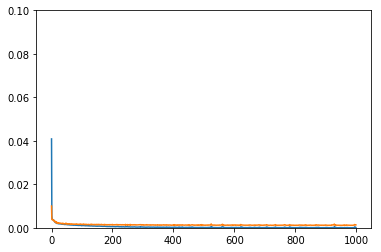

In [4]:
model = init_model()
history = model.fit(train_X, train_Y, 
                    epochs=1000, 
                    batch_size=20,
                    validation_data=(test_X, test_Y), 
                    verbose=2)

train_score = model.evaluate(train_X, train_Y, batch_size=20)
test_score = model.evaluate(test_X, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.ylim(0,0.1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

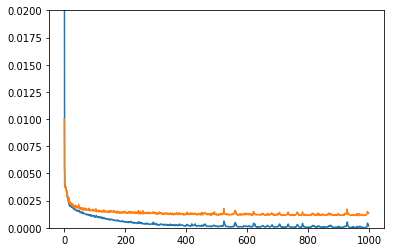

In [5]:
plt.ylim(0,0.02)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

Test 0
True shape: [0.2       0.1       0.2       0.2370452 0.3       0.3      ]
Predicted shape: [[0.18852907 0.12184092 0.19097948 0.2366673  0.2893437  0.29354876]]

Predicted shape: [[0.20834994 0.0913592  0.1809254  0.2334576  0.32131976 0.30321696]]



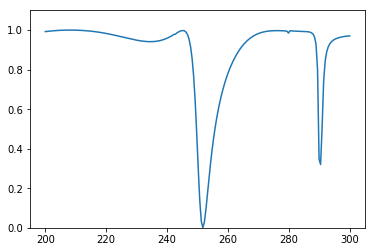

Test 1
True shape: [0.3        0.2        0.21968701 0.25051498 0.3        0.2963065 ]
Predicted shape: [[0.29541796 0.279724   0.19084165 0.24560007 0.2903424  0.20907176]]

Predicted shape: [[0.3042953  0.26179406 0.22098494 0.23132595 0.3065059  0.2534112 ]]



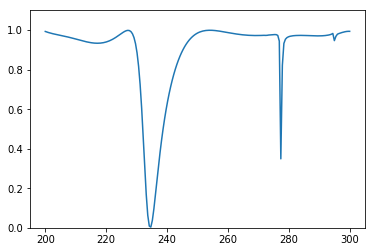

Test 2
True shape: [0.2        0.21057    0.22825356 0.25606269 0.3        0.3       ]
Predicted shape: [[0.17966047 0.19207898 0.19755098 0.29725352 0.30824223 0.30943906]]

Predicted shape: [[0.19935107 0.20995915 0.22652638 0.24885881 0.2904756  0.2892629 ]]



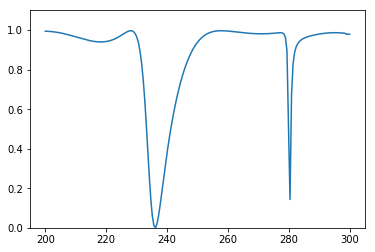

Test 3
True shape: [0.2963065  0.3        0.2        0.21968701 0.25051498 0.3       ]
Predicted shape: [[0.22273389 0.21785176 0.18710521 0.28583652 0.25556713 0.29897383]]

Predicted shape: [[0.28923684 0.2960036  0.21844053 0.21478084 0.25336254 0.30167288]]



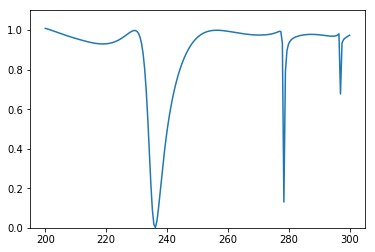

Test 4
True shape: [0.3        0.2963065  0.3        0.2        0.2        0.19753767]
Predicted shape: [[0.29852673 0.29440954 0.3015982  0.19856912 0.20746909 0.19866711]]

Predicted shape: [[0.30641198 0.2920827  0.29521704 0.2017321  0.19489937 0.19784407]]



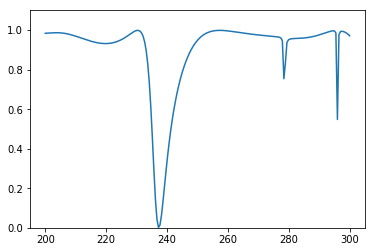

Test 5
True shape: [0.2       0.3       0.2370452 0.2       0.1       0.1      ]
Predicted shape: [[0.18949696 0.29190928 0.25007844 0.18832076 0.11868909 0.11375622]]

Predicted shape: [[0.20238695 0.29249752 0.2384021  0.19595358 0.10980392 0.09907369]]



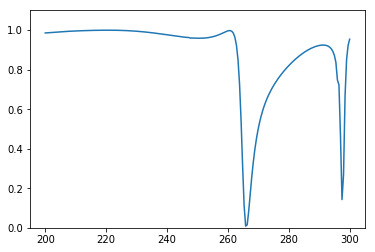

Test 6
True shape: [0.3 0.2 0.3 0.2 0.1 0.2]
Predicted shape: [[0.29830787 0.22083747 0.29776496 0.20388258 0.14577737 0.09621162]]

Predicted shape: [[0.2885264  0.23297179 0.265774   0.20739493 0.12421579 0.14334477]]



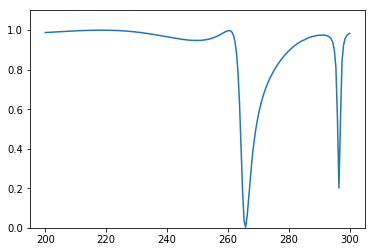

Test 7
True shape: [0.19753767 0.2        0.2        0.2        0.3        0.2963065 ]
Predicted shape: [[0.19940108 0.20037359 0.19980326 0.19837418 0.29655942 0.29315355]]

Predicted shape: [[0.20002547 0.19971365 0.20230341 0.18975791 0.29396042 0.31891564]]



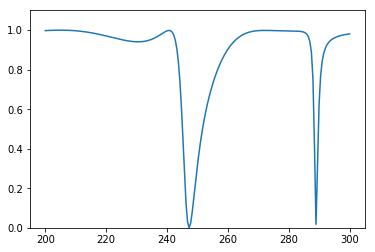

Test 8
True shape: [0.2 0.3 0.2 0.3 0.3 0.4]
Predicted shape: [[0.1979292  0.2147043  0.23538703 0.28496903 0.32394373 0.39513564]]

Predicted shape: [[0.21505451 0.28933755 0.20928314 0.28522688 0.3009427  0.41421315]]



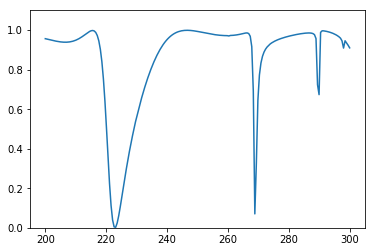

Test 9
True shape: [0.26730196 0.27063391 0.28105791 0.3        0.2        0.19753767]
Predicted shape: [[0.29003114 0.29784873 0.21396416 0.21875313 0.2627089  0.1806073 ]]

Predicted shape: [[0.27612498 0.2756936  0.2885661  0.29064173 0.2096174  0.20200525]]



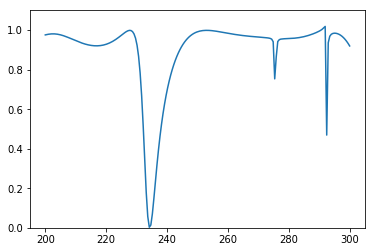

Test 10
True shape: [0.26730196 0.27063391 0.28105791 0.3        0.2        0.3       ]
Predicted shape: [[0.18898907 0.24414563 0.30590054 0.31273583 0.2300386  0.21336038]]

Predicted shape: [[0.27393097 0.2910865  0.30696473 0.2582782  0.22473298 0.21640766]]



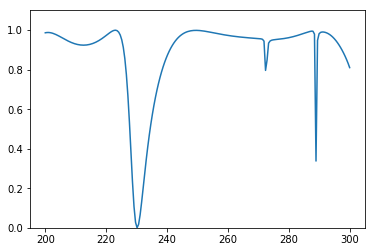

Test 11
True shape: [0.4        0.3        0.2        0.19753767 0.2        0.1       ]
Predicted shape: [[0.3324086  0.28056443 0.22806183 0.2032451  0.19336726 0.12421999]]

Predicted shape: [[0.40654147 0.3035016  0.19272992 0.18931893 0.19501828 0.12250438]]



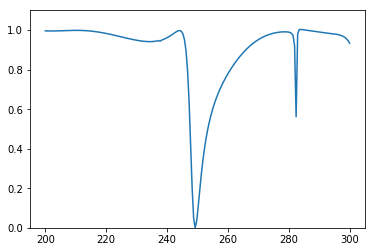

Test 12
True shape: [0.1902113  0.19258231 0.2        0.2        0.3        0.2963065 ]
Predicted shape: [[0.20640466 0.17311534 0.18748516 0.21007103 0.29162267 0.3122042 ]]

Predicted shape: [[0.18838254 0.18774003 0.19357604 0.19052625 0.2911413  0.3249579 ]]



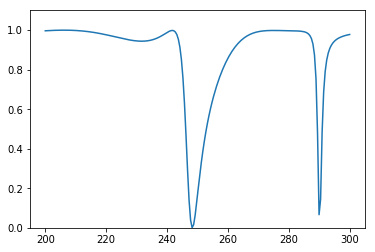

Test 13
True shape: [0.3        0.2        0.19753767 0.2        0.19753767 0.2       ]
Predicted shape: [[0.29856876 0.19597137 0.19584143 0.1966174  0.19407085 0.19808014]]

Predicted shape: [[0.3069204  0.21129864 0.20531717 0.20456803 0.21418677 0.218609  ]]



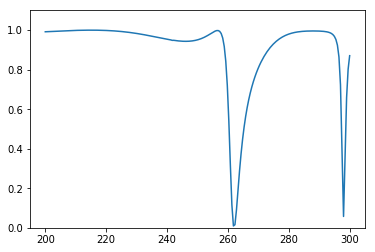

Test 14
True shape: [0.3 0.2 0.3 0.3 0.3 0.2]
Predicted shape: [[0.27994102 0.22056103 0.2179229  0.29195324 0.25952548 0.21749003]]

Predicted shape: [[0.287279   0.21830791 0.2885409  0.2708792  0.288505   0.28369462]]



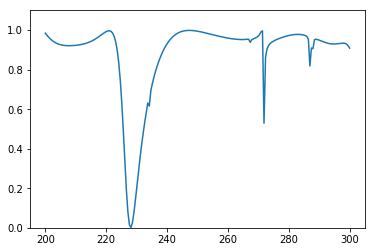

Test 15
True shape: [0.2        0.2        0.2        0.3        0.2        0.19753767]
Predicted shape: [[0.1890102  0.19956735 0.19815779 0.29385236 0.20787278 0.18919258]]

Predicted shape: [[0.19989887 0.19523254 0.20769128 0.29391915 0.20077667 0.20111957]]



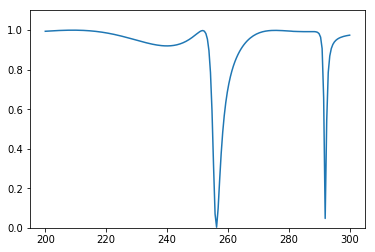

Test 16
True shape: [0.3        0.3        0.2        0.19753767 0.2        0.3       ]
Predicted shape: [[0.2946746  0.30283356 0.20145175 0.20535365 0.19880052 0.30587834]]

Predicted shape: [[0.2984947  0.29944277 0.20669118 0.19789839 0.19404285 0.31524026]]



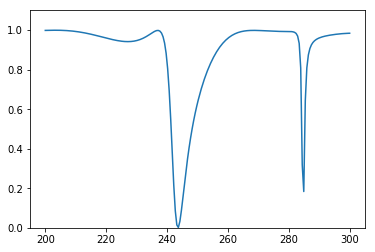

Test 17
True shape: [0.2 0.3 0.2 0.2 0.3 0.4]
Predicted shape: [[0.22115368 0.18447497 0.18218789 0.28712785 0.30434248 0.44029343]]

Predicted shape: [[0.22192502 0.28822798 0.19127432 0.20368758 0.2920078  0.3852822 ]]



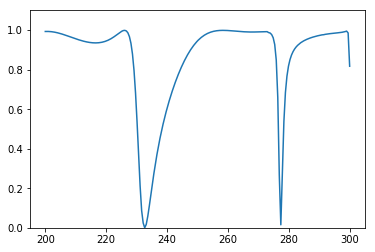

Test 18
True shape: [0.3       0.3       0.2963065 0.3       0.3       0.4      ]
Predicted shape: [[0.28806067 0.29397544 0.29994023 0.29511464 0.28858805 0.40977168]]

Predicted shape: [[0.29836214 0.29664135 0.29377347 0.29958218 0.30018994 0.4058687 ]]



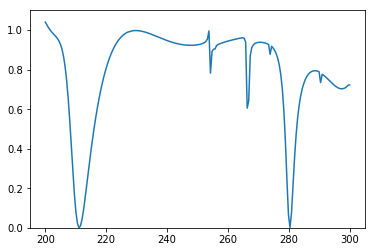

Test 19
True shape: [0.1 0.2 0.2 0.2 0.3 0.3]
Predicted shape: [[0.09453523 0.2005041  0.20327654 0.19458297 0.2899749  0.29441774]]

Predicted shape: [[0.09503862 0.19248244 0.19196764 0.19795114 0.30062756 0.3210474 ]]



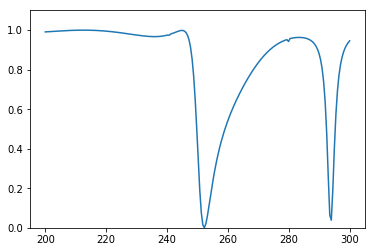

Test 20
True shape: [0.2        0.2370452  0.3        0.28105791 0.27063391 0.26730196]
Predicted shape: [[0.24713814 0.23525143 0.26485643 0.27940947 0.3048568  0.23943   ]]

Predicted shape: [[0.21430036 0.2352188  0.31402564 0.2685981  0.2684775  0.26841074]]



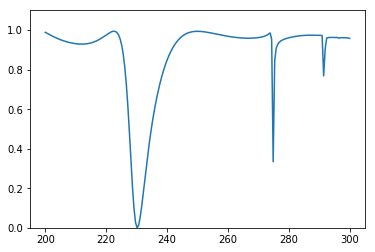

Test 21
True shape: [0.3 0.2 0.1 0.2 0.3 0.3]
Predicted shape: [[0.2928179  0.18886656 0.10567993 0.19410554 0.30076963 0.29237035]]

Predicted shape: [[0.30022666 0.19062522 0.11203274 0.19728756 0.2779376  0.31777894]]



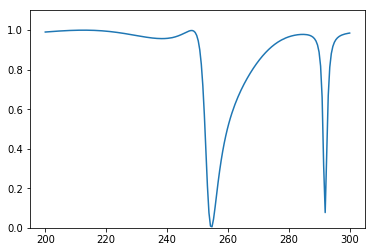

Test 22
True shape: [0.2        0.2        0.3        0.28105791 0.27063391 0.26730196]
Predicted shape: [[0.19833985 0.20035163 0.2871853  0.28776705 0.2648526  0.27649763]]

Predicted shape: [[0.18541136 0.21012875 0.31604803 0.2922135  0.27909324 0.26084793]]



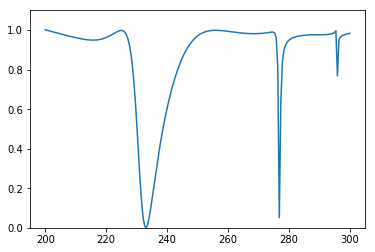

Test 23
True shape: [0.2 0.3 0.3 0.2 0.1 0.1]
Predicted shape: [[0.21341291 0.29726446 0.30577153 0.19994253 0.10645507 0.11339209]]

Predicted shape: [[0.18514502 0.31289417 0.29563326 0.18812087 0.10694607 0.10619748]]



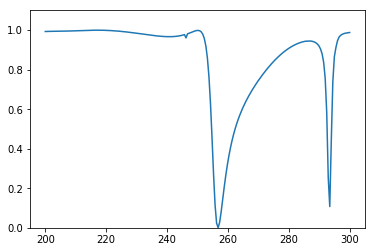

Test 24
True shape: [0.3        0.2963065  0.3        0.2        0.13169178 0.1       ]
Predicted shape: [[0.29445335 0.2958349  0.30387652 0.20298478 0.12743211 0.12027324]]

Predicted shape: [[0.30712125 0.29833955 0.29025    0.1937997  0.13218738 0.1128374 ]]



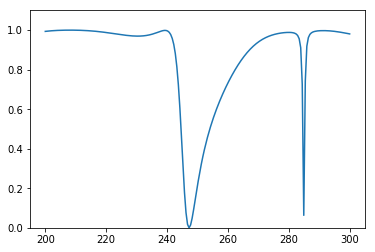

Test 25
True shape: [0.2       0.2370452 0.3       0.3       0.2       0.2      ]
Predicted shape: [[0.18292487 0.27383232 0.3090128  0.24358359 0.19328073 0.24224992]]

Predicted shape: [[0.20009854 0.2385892  0.318174   0.2941511  0.20194215 0.19563729]]



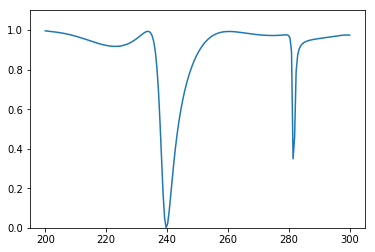

Test 26
True shape: [0.3        0.2        0.21968701 0.25051498 0.3        0.4       ]
Predicted shape: [[0.30898628 0.25530273 0.23707968 0.19668755 0.29195207 0.34373835]]

Predicted shape: [[0.2848754  0.26539636 0.18442035 0.21700588 0.3088101  0.40286398]]



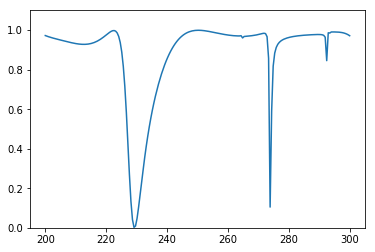

Test 27
True shape: [0.2        0.21057    0.22825356 0.25606269 0.3        0.2       ]
Predicted shape: [[0.17535079 0.21998838 0.2046516  0.22310582 0.27350542 0.28450698]]

Predicted shape: [[0.21075287 0.22151855 0.2220504  0.26697075 0.29118592 0.21210949]]



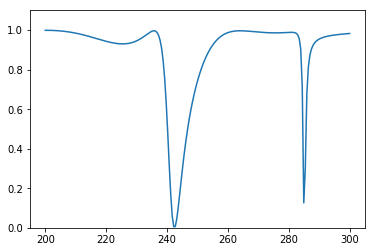

Test 28
True shape: [0.3        0.25606269 0.22825356 0.21057    0.2        0.1       ]
Predicted shape: [[0.30678147 0.30362105 0.21827963 0.19386321 0.18779097 0.15099983]]

Predicted shape: [[0.32446516 0.28462374 0.2149027  0.22238675 0.1594615  0.18840876]]



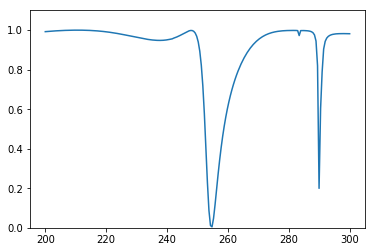

Test 29
True shape: [0.3 0.2 0.3 0.2 0.3 0.4]
Predicted shape: [[0.22901553 0.24853542 0.27196762 0.18063313 0.29792657 0.42678997]]

Predicted shape: [[0.2683093  0.21965829 0.27080286 0.21176675 0.29669294 0.41887352]]



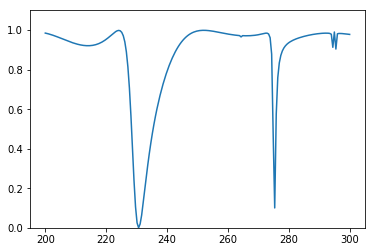

Test 30
True shape: [0.19753767 0.2        0.3        0.2        0.3        0.3       ]
Predicted shape: [[0.1905545  0.20035136 0.30792034 0.2024652  0.29218376 0.29694447]]

Predicted shape: [[0.2104404  0.19947177 0.2879758  0.19626331 0.29522935 0.30337945]]



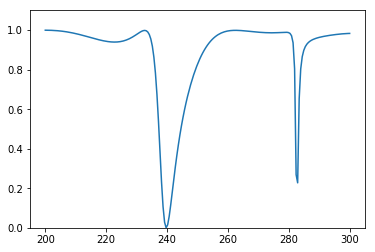

Test 31
True shape: [0.2963065  0.3        0.2370452  0.2        0.2        0.19753767]
Predicted shape: [[0.29107946 0.30077124 0.23913652 0.20506826 0.20138577 0.21902037]]

Predicted shape: [[0.3075596  0.29360974 0.2532615  0.20185888 0.19345659 0.22320496]]



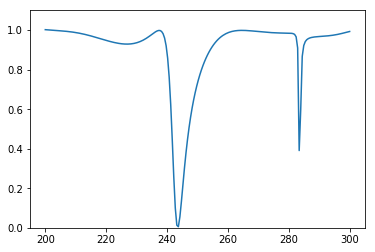

Test 32
True shape: [0.4        0.3        0.25606269 0.22825356 0.21057    0.2       ]
Predicted shape: [[0.32865798 0.26923108 0.29069453 0.25502664 0.20666234 0.20452611]]

Predicted shape: [[0.4101571  0.3002454  0.2752329  0.23496017 0.19009179 0.22729455]]



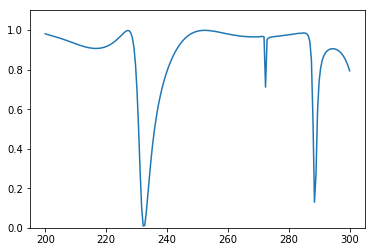

Test 33
True shape: [0.3        0.2370452  0.2        0.19753767 0.2        0.3       ]
Predicted shape: [[0.26061177 0.24283952 0.20292082 0.19731554 0.21183266 0.281993  ]]

Predicted shape: [[0.2974233  0.22525403 0.21911791 0.19683054 0.189112   0.3297945 ]]



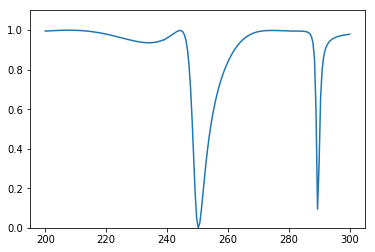

Test 34
True shape: [0.19753767 0.2        0.19753767 0.2        0.2370452  0.3       ]
Predicted shape: [[0.19678995 0.21286401 0.20569855 0.19158489 0.25767496 0.2513762 ]]

Predicted shape: [[0.20592812 0.20090204 0.19838655 0.20438775 0.23534293 0.30630022]]



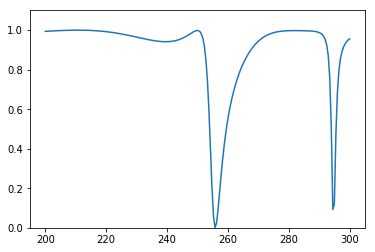

Test 35
True shape: [0.2 0.3 0.2 0.1 0.2 0.2]
Predicted shape: [[0.18463734 0.30066794 0.18831244 0.10483339 0.21632013 0.23319678]]

Predicted shape: [[0.22604644 0.29053462 0.2113344  0.08931831 0.1849967  0.21741207]]



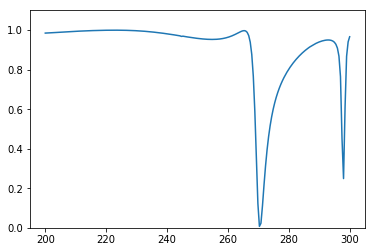

Test 36
True shape: [0.2963065 0.3       0.4       0.5       0.4       0.4      ]
Predicted shape: [[0.29789034 0.3048514  0.38743636 0.49598283 0.4000132  0.39689723]]

Predicted shape: [[0.29360104 0.2997656  0.40628207 0.49547893 0.41344586 0.40363473]]



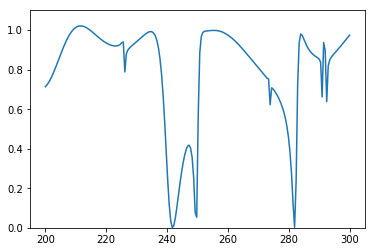

Test 37
True shape: [0.1       0.2       0.2       0.2370452 0.3       0.2      ]
Predicted shape: [[0.13130495 0.2148883  0.18360248 0.21275195 0.2892571  0.3036107 ]]

Predicted shape: [[0.09725851 0.18773976 0.20366767 0.22599652 0.3062346  0.2215772 ]]



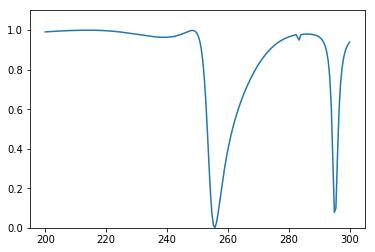

Test 38
True shape: [0.4       0.3       0.2370452 0.2       0.2370452 0.3      ]
Predicted shape: [[0.2763127  0.22323436 0.27119952 0.32857877 0.23480386 0.22402789]]

Predicted shape: [[0.41232592 0.2914759  0.24195066 0.18940285 0.22161898 0.32048073]]



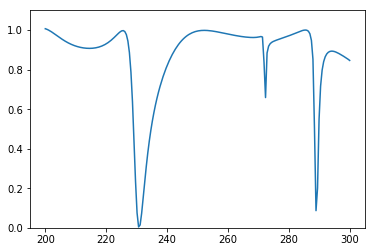

Test 39
True shape: [0.2963065  0.3        0.2        0.19753767 0.2        0.1       ]
Predicted shape: [[0.2646907  0.30548227 0.23509723 0.1897701  0.17916241 0.11553105]]

Predicted shape: [[0.2917955  0.30392057 0.1932756  0.20896488 0.20209968 0.09521109]]



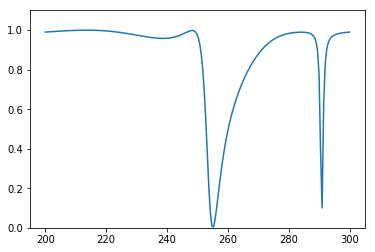

Test 40
True shape: [0.19753767 0.2        0.3        0.3        0.28887347 0.28531695]
Predicted shape: [[0.28698498 0.23661381 0.21580517 0.30697793 0.2805424  0.31392345]]

Predicted shape: [[0.20506954 0.24586657 0.29553276 0.28901517 0.2602534  0.302552  ]]



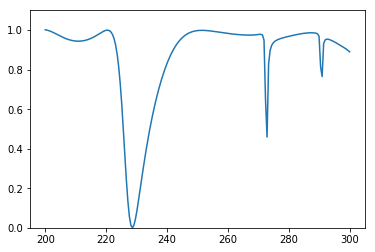

Test 41
True shape: [0.2        0.2        0.19753767 0.2        0.3        0.2963065 ]
Predicted shape: [[0.19797128 0.19641575 0.1942189  0.19590035 0.2967274  0.29579666]]

Predicted shape: [[0.20395759 0.19975528 0.19853345 0.18705353 0.2896588  0.32128093]]



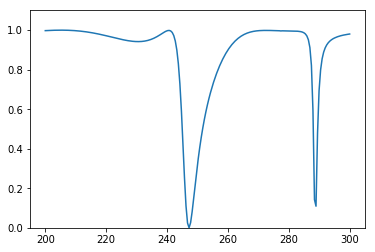

Test 42
True shape: [0.19753767 0.2        0.2        0.21968701 0.25051498 0.3       ]
Predicted shape: [[0.17936447 0.22323674 0.24444014 0.20409304 0.22259079 0.2398177 ]]

Predicted shape: [[0.2001495  0.20048687 0.19177192 0.1937002  0.2587627  0.2791167 ]]



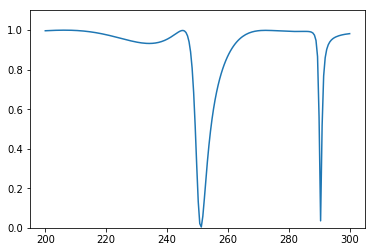

Test 43
True shape: [0.3        0.3        0.2        0.19753767 0.2        0.2       ]
Predicted shape: [[0.3099457  0.29776758 0.20474076 0.20061532 0.208135   0.2017009 ]]

Predicted shape: [[0.31039536 0.2944616  0.20470199 0.19620085 0.20295759 0.21977071]]



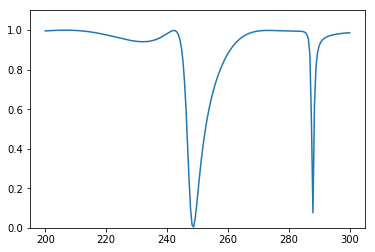

Test 44
True shape: [0.2        0.19507534 0.19507534 0.2        0.2370452  0.3       ]
Predicted shape: [[0.2519493  0.2049084  0.2194382  0.18291098 0.21271175 0.27937165]]

Predicted shape: [[0.20139486 0.18617406 0.20439705 0.2146945  0.24569911 0.3074166 ]]



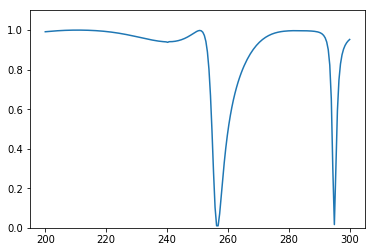

Test 45
True shape: [0.2       0.2370452 0.3       0.2       0.2       0.3      ]
Predicted shape: [[0.24005261 0.21700996 0.23526314 0.22283188 0.2827842  0.25749284]]

Predicted shape: [[0.20310119 0.25436035 0.29336217 0.2091729  0.20791255 0.2765732 ]]



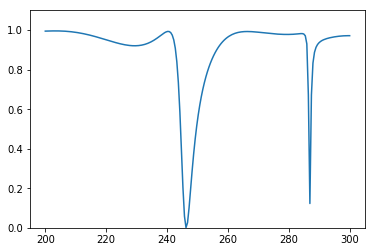

Test 46
True shape: [0.3       0.2       0.3       0.2370452 0.2       0.3      ]
Predicted shape: [[0.2650721  0.27612254 0.22085837 0.19535351 0.28602085 0.24743323]]

Predicted shape: [[0.28474164 0.23468822 0.25168198 0.26060575 0.23309764 0.29290435]]



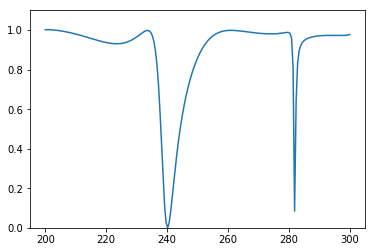

Test 47
True shape: [0.2        0.19753767 0.2        0.21968701 0.25051498 0.3       ]
Predicted shape: [[0.16581142 0.21625316 0.24808773 0.20156887 0.22139741 0.28403643]]

Predicted shape: [[0.20450965 0.20225465 0.1996656  0.18578735 0.25553542 0.28834864]]



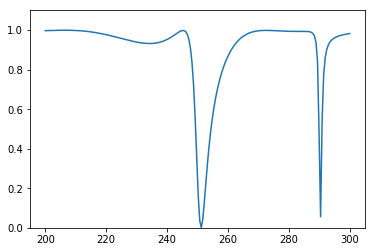

Test 48
True shape: [0.3        0.2        0.2370452  0.3        0.2        0.19753767]
Predicted shape: [[0.28087273 0.21989343 0.22335482 0.30178612 0.18962713 0.20749697]]

Predicted shape: [[0.28697214 0.20516899 0.23901355 0.2885369  0.20664828 0.21262524]]



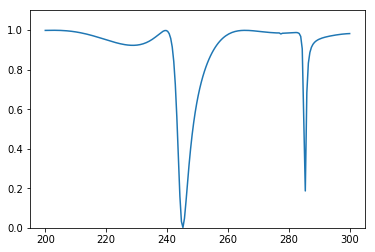

Test 49
True shape: [0.2        0.2        0.3        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.18542382 0.20459926 0.2998916  0.19704524 0.18364994 0.19494134]]

Predicted shape: [[0.19856352 0.20669118 0.29795644 0.19368494 0.18605512 0.19142829]]



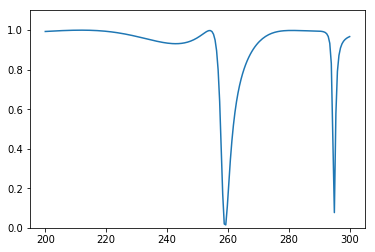

Test 50
True shape: [0.3        0.3        0.2370452  0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.29444677 0.2361466  0.25441903 0.2391989  0.19332483 0.16468413]]

Predicted shape: [[0.31050047 0.29375654 0.2393384  0.1945371  0.19274612 0.18925121]]



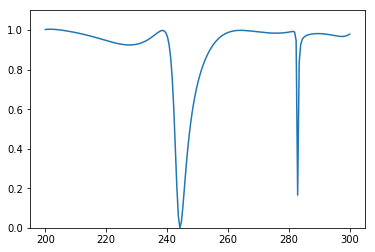

Test 51
True shape: [0.1       0.2       0.2370452 0.3       0.3       0.2963065]
Predicted shape: [[0.08962989 0.18609193 0.2400907  0.29202485 0.29323137 0.30174   ]]

Predicted shape: [[0.09653839 0.20050853 0.22250554 0.29723936 0.3072565  0.30012468]]



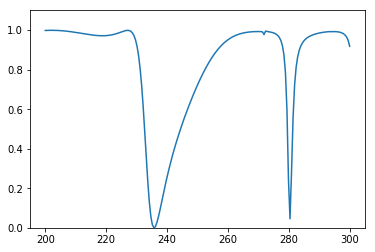

Test 52
True shape: [0.2963065 0.3       0.2       0.2       0.2       0.1      ]
Predicted shape: [[0.2994358  0.3055901  0.2144242  0.19436863 0.18178605 0.1119903 ]]

Predicted shape: [[0.2931536  0.3124102  0.18952921 0.20615226 0.20618936 0.09531648]]



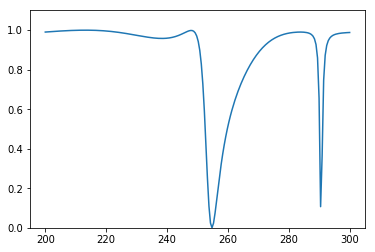

Test 53
True shape: [0.2        0.3        0.2        0.3        0.28887347 0.28531695]
Predicted shape: [[0.28680032 0.25179586 0.19051942 0.29802936 0.29337296 0.2787851 ]]

Predicted shape: [[0.20863897 0.26731372 0.23009318 0.29190004 0.2856405  0.30837625]]



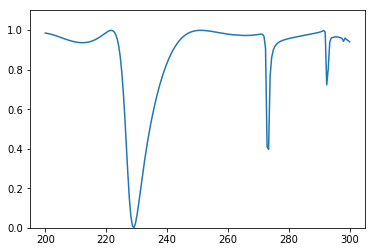

Test 54
True shape: [0.19753767 0.2        0.2        0.2        0.3        0.2       ]
Predicted shape: [[0.18410504 0.21086562 0.202746   0.19357789 0.30027443 0.19000828]]

Predicted shape: [[0.19217828 0.19377089 0.1903224  0.19351056 0.30242345 0.19482127]]



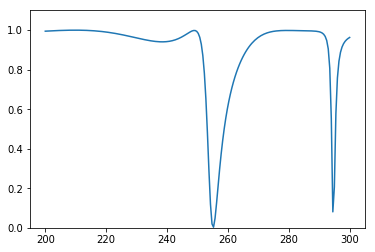

Test 55
True shape: [0.2       0.3       0.2370452 0.2       0.2       0.2      ]
Predicted shape: [[0.21736181 0.30804604 0.2271192  0.20137632 0.2146602  0.2001549 ]]

Predicted shape: [[0.19143465 0.29164404 0.24475667 0.20140103 0.21108633 0.22332388]]



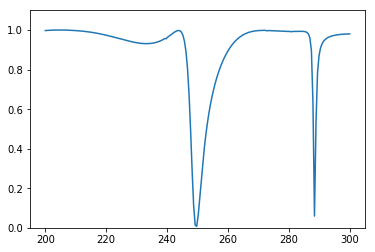

Test 56
True shape: [0.19753767 0.2        0.2370452  0.3        0.3        0.3       ]
Predicted shape: [[0.19478065 0.21720582 0.2683984  0.27991873 0.2954802  0.2949718 ]]

Predicted shape: [[0.1928587  0.19459823 0.24207523 0.28801405 0.30314708 0.2974065 ]]



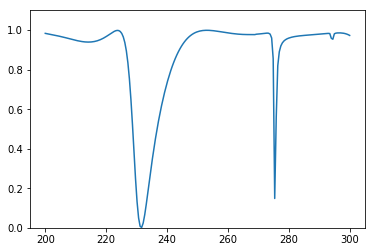

Test 57
True shape: [0.2        0.3        0.2        0.19753767 0.2        0.19753767]
Predicted shape: [[0.19505027 0.30523974 0.20545834 0.18788284 0.19651917 0.18465666]]

Predicted shape: [[0.2096889  0.2859391  0.19775671 0.19611618 0.2112084  0.20250681]]



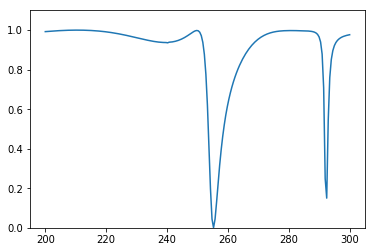

Test 58
True shape: [0.3 0.2 0.1 0.2 0.3 0.4]
Predicted shape: [[0.1069389  0.18579331 0.21471298 0.3105017  0.29551116 0.19559403]]

Predicted shape: [[0.30470896 0.19276315 0.13157967 0.18433145 0.2948359  0.4051144 ]]



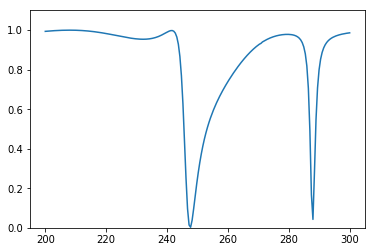

Test 59
True shape: [0.3        0.28503952 0.27802091 0.27802091 0.28503952 0.3       ]
Predicted shape: [[0.26158482 0.2632491  0.298166   0.3161347  0.28796476 0.2728636 ]]

Predicted shape: [[0.28857923 0.29611325 0.28587216 0.2735541  0.2772531  0.29762334]]



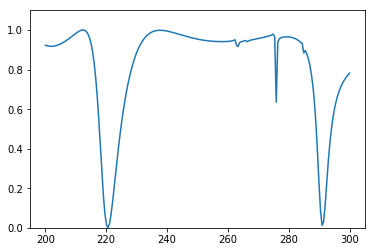

Test 60
True shape: [0.3        0.2        0.3        0.2        0.19753767 0.2       ]
Predicted shape: [[0.27892634 0.20729935 0.2844473  0.20502561 0.20695247 0.18009007]]

Predicted shape: [[0.2909894  0.20852187 0.282036   0.22436619 0.1813635  0.19252065]]



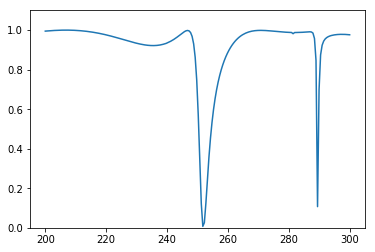

Test 61
True shape: [0.3        0.3        0.3        0.2        0.13169178 0.1       ]
Predicted shape: [[0.28953415 0.29320467 0.30345094 0.20957106 0.11072214 0.1926637 ]]

Predicted shape: [[0.3023861  0.2982022  0.2900893  0.19221905 0.1333126  0.10837805]]



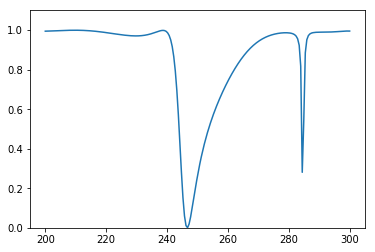

Test 62
True shape: [0.28531695 0.28887347 0.3        0.2370452  0.2        0.2       ]
Predicted shape: [[0.29255152 0.29895782 0.2708134  0.23225525 0.21126615 0.22767211]]

Predicted shape: [[0.29834324 0.27297693 0.28736728 0.21678358 0.22340739 0.23301876]]



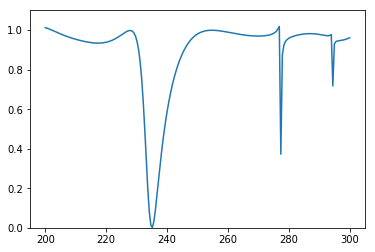

Test 63
True shape: [0.19753767 0.2        0.2        0.2        0.2370452  0.3       ]
Predicted shape: [[0.18886048 0.21568713 0.19798955 0.19522506 0.26306173 0.24866673]]

Predicted shape: [[0.20054498 0.19654015 0.19483519 0.20137239 0.2305019  0.31104976]]



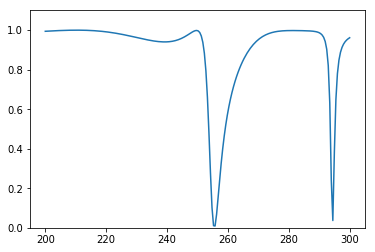

Test 64
True shape: [0.2        0.3        0.25051498 0.21968701 0.2        0.19753767]
Predicted shape: [[0.2165356  0.29563785 0.24268281 0.22567543 0.2024884  0.21613929]]

Predicted shape: [[0.19397354 0.28976095 0.2478843  0.22330147 0.19501887 0.20614739]]



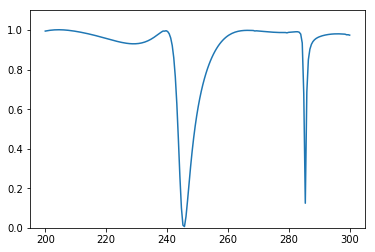

Test 65
True shape: [0.09876883 0.1        0.2        0.2370452  0.3        0.2963065 ]
Predicted shape: [[0.09181875 0.09301734 0.19509566 0.23083162 0.29482153 0.29705724]]

Predicted shape: [[0.09075391 0.10483491 0.18646315 0.22807145 0.30043986 0.33557078]]



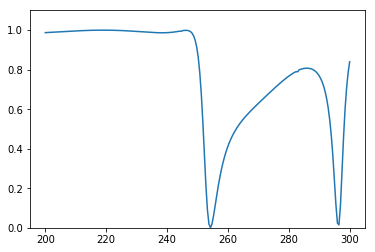

Test 66
True shape: [0.2        0.21968701 0.25051498 0.3        0.28887347 0.28531695]
Predicted shape: [[0.19287539 0.22330028 0.24043378 0.3020641  0.28808463 0.30219612]]

Predicted shape: [[0.18823844 0.20917991 0.2543739  0.29635957 0.29178768 0.280475  ]]



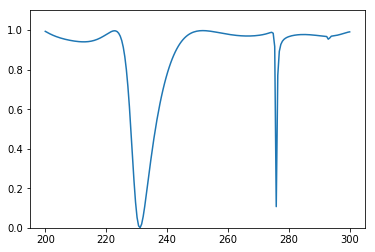

Test 67
True shape: [0.19753767 0.2        0.2        0.3        0.3        0.3       ]
Predicted shape: [[0.19121432 0.19733173 0.19801223 0.29671627 0.30248055 0.29251915]]

Predicted shape: [[0.20224851 0.20285714 0.1992701  0.29222775 0.30092105 0.29605338]]



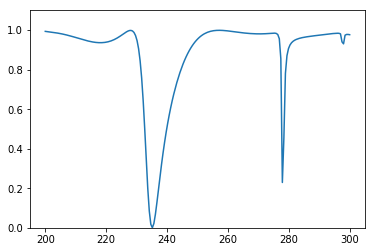

Test 68
True shape: [0.2        0.19753767 0.2        0.3        0.2        0.2       ]
Predicted shape: [[0.18802455 0.20048022 0.19588423 0.2930805  0.20601586 0.19089456]]

Predicted shape: [[0.19252929 0.19143501 0.20397589 0.28667754 0.19306819 0.20751911]]



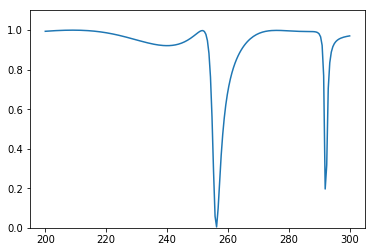

Test 69
True shape: [0.2963065  0.3        0.2        0.2        0.19753767 0.2       ]
Predicted shape: [[0.31185287 0.2983019  0.20581326 0.19779643 0.20912977 0.2026318 ]]

Predicted shape: [[0.29893476 0.29360265 0.19776335 0.19924879 0.19644238 0.21780333]]



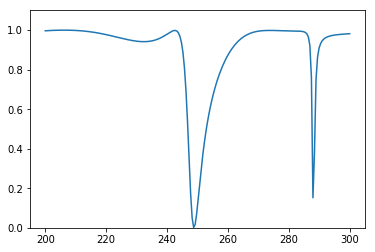

Test 70
True shape: [0.2        0.2370452  0.3        0.2        0.13169178 0.1       ]
Predicted shape: [[0.18603817 0.26117185 0.2860433  0.18623975 0.12115383 0.13605608]]

Predicted shape: [[0.19022179 0.25228366 0.28954193 0.19944996 0.11219548 0.11189795]]



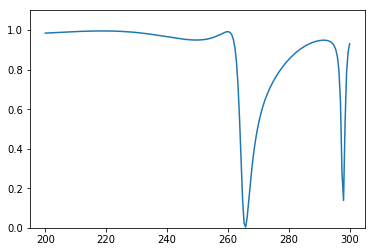

Test 71
True shape: [0.3       0.3       0.2       0.3       0.2370452 0.2      ]
Predicted shape: [[0.26333177 0.25392777 0.22985312 0.28804058 0.20711192 0.19248551]]

Predicted shape: [[0.3144893  0.29039294 0.19557285 0.30351216 0.2292716  0.21233848]]



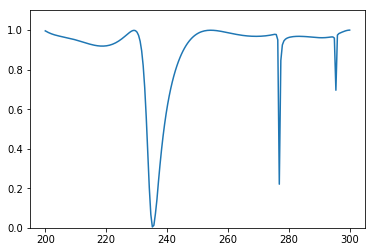

Test 72
True shape: [0.3       0.2       0.2370452 0.3       0.2       0.3      ]
Predicted shape: [[0.20444247 0.28649366 0.24726266 0.19209439 0.2500682  0.3006549 ]]

Predicted shape: [[0.26796314 0.22432217 0.25176942 0.2659753  0.2335762  0.29881757]]



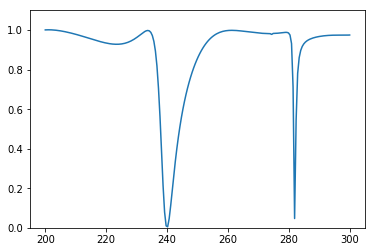

Test 73
True shape: [0.3        0.3        0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.3095119  0.29803348 0.2046664  0.2008425  0.20490721 0.20217574]]

Predicted shape: [[0.31436002 0.2964524  0.20756423 0.19949344 0.20282818 0.22135745]]



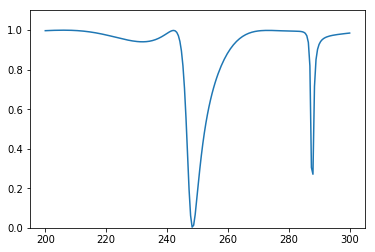

Test 74
True shape: [0.1       0.2       0.3       0.2370452 0.2       0.2      ]
Predicted shape: [[0.09421042 0.1984694  0.29586726 0.20832756 0.20703018 0.1879544 ]]

Predicted shape: [[0.0884634  0.20952341 0.27206987 0.24524987 0.20973743 0.2109039 ]]



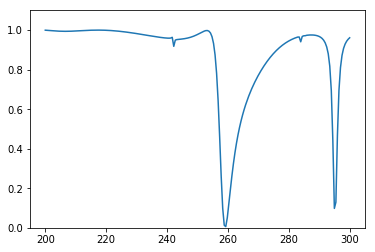

Test 75
True shape: [0.3        0.4        0.5        0.4        0.5        0.49384417]
Predicted shape: [[0.2680326  0.37913597 0.50436354 0.39536    0.50815976 0.5119258 ]]

Predicted shape: [[0.30897152 0.3917721  0.49098432 0.4092363  0.5108929  0.48881066]]



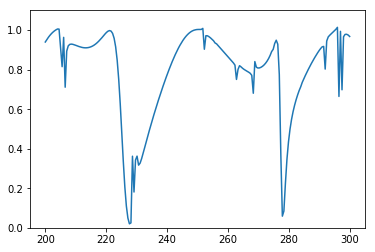

Test 76
True shape: [0.3        0.2        0.2        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.2965979  0.20430604 0.19897687 0.19173989 0.1916254  0.203885  ]]

Predicted shape: [[0.31222832 0.20931914 0.19407788 0.1921711  0.20866516 0.2104749 ]]



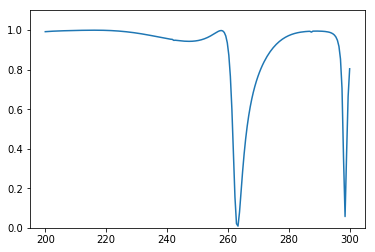

Test 77
True shape: [0.2        0.3        0.3        0.2        0.19753767 0.2       ]
Predicted shape: [[0.20887384 0.26897275 0.23815054 0.2197262  0.20145486 0.2951365 ]]

Predicted shape: [[0.2192631  0.29892963 0.2981299  0.20538604 0.19406141 0.18308909]]



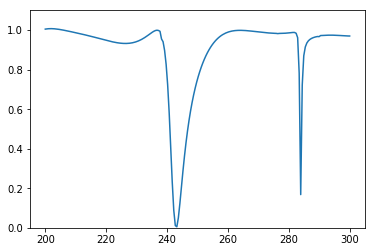

Test 78
True shape: [0.2963065  0.3        0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.30845314 0.29743457 0.20511973 0.2000452  0.20806958 0.20337029]]

Predicted shape: [[0.30510652 0.29511002 0.20188424 0.1962884  0.2030631  0.21915497]]



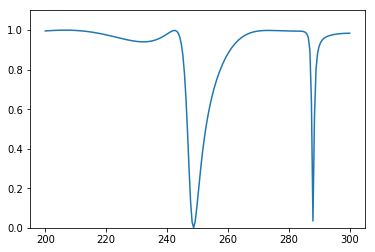

Test 79
True shape: [0.26730196 0.27063391 0.28105791 0.3        0.2        0.2       ]
Predicted shape: [[0.2856506  0.30259833 0.2119756  0.22383124 0.26273367 0.18107508]]

Predicted shape: [[0.27629438 0.28130645 0.28821722 0.2899382  0.20910057 0.19835846]]



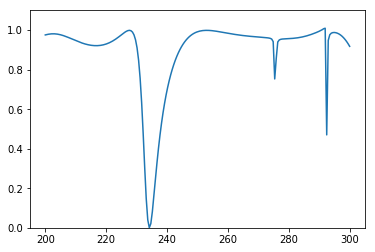

Test 80
True shape: [0.2963065  0.3        0.25051498 0.21968701 0.2        0.2       ]
Predicted shape: [[0.28046042 0.29824865 0.29332757 0.22417289 0.19646761 0.20255798]]

Predicted shape: [[0.31541985 0.2992637  0.25626642 0.21677074 0.20443721 0.20631504]]



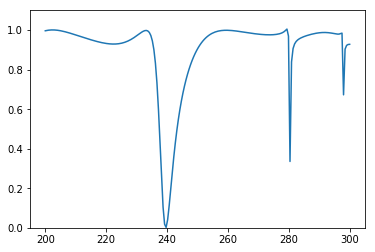

Test 81
True shape: [0.2963065 0.3       0.2370452 0.2       0.2370452 0.3      ]
Predicted shape: [[0.2995142  0.29431146 0.20971319 0.29506254 0.20350553 0.28586587]]

Predicted shape: [[0.3031266  0.2912547  0.23306    0.1921758  0.25124946 0.2798023 ]]



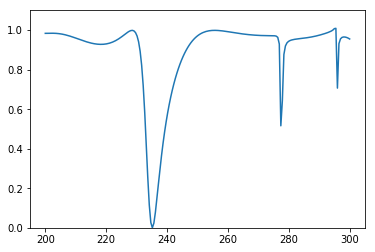

Test 82
True shape: [0.19753767 0.2        0.3        0.2        0.19753767 0.2       ]
Predicted shape: [[0.17282721 0.19847518 0.30384994 0.20490605 0.18505397 0.18797766]]

Predicted shape: [[0.20134684 0.20677543 0.30077225 0.20244452 0.1972716  0.21582912]]



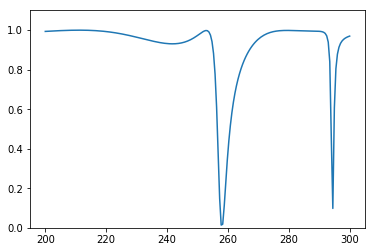

Test 83
True shape: [0.19753767 0.2        0.3        0.25051498 0.21968701 0.2       ]
Predicted shape: [[0.21028915 0.20752361 0.30420867 0.24714312 0.2049664  0.20377128]]

Predicted shape: [[0.19838643 0.20266262 0.31293833 0.23385131 0.21938913 0.21801902]]



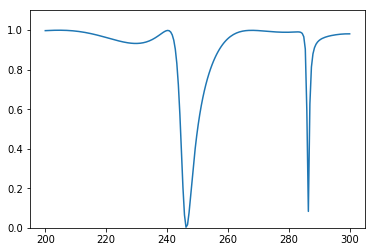

Test 84
True shape: [0.4       0.3       0.2370452 0.2       0.2       0.2      ]
Predicted shape: [[0.35404563 0.29404157 0.2770174  0.20278195 0.2012897  0.20937271]]

Predicted shape: [[0.400639   0.27992898 0.2353107  0.17132911 0.21921219 0.2131663 ]]



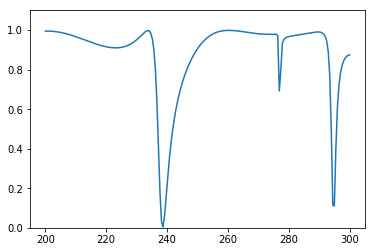

Test 85
True shape: [0.2       0.2       0.2370452 0.3       0.3       0.3      ]
Predicted shape: [[0.20112452 0.21861634 0.25798002 0.27640843 0.29429626 0.30928448]]

Predicted shape: [[0.19910464 0.1990737  0.24312612 0.2876363  0.3085532  0.3061595 ]]



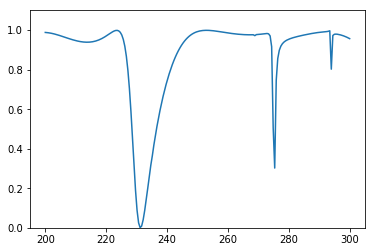

Test 86
True shape: [0.19753767 0.2        0.2        0.3        0.3        0.2       ]
Predicted shape: [[0.18716007 0.19558382 0.20550019 0.3005835  0.2950838  0.19980761]]

Predicted shape: [[0.25023663 0.19617513 0.21071392 0.26999846 0.28915566 0.2409955 ]]



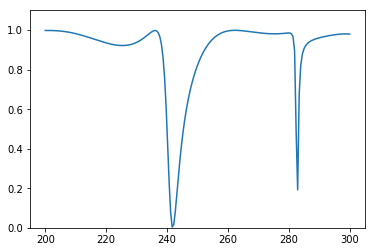

Test 87
True shape: [0.3 0.2 0.2 0.2 0.3 0.3]
Predicted shape: [[0.23726669 0.19357175 0.20165172 0.21475354 0.30630267 0.28824174]]

Predicted shape: [[0.28963214 0.21039954 0.20638031 0.2071006  0.30100173 0.31563526]]



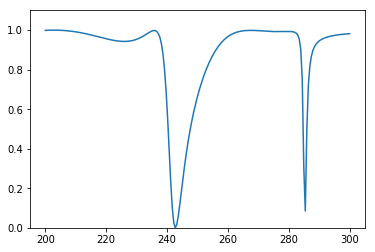

Test 88
True shape: [0.19753767 0.2        0.3        0.3        0.2        0.19753767]
Predicted shape: [[0.20002276 0.19100589 0.2963603  0.30672956 0.19349927 0.1924414 ]]

Predicted shape: [[0.18552968 0.19027719 0.29607165 0.29795158 0.2119196  0.20396541]]



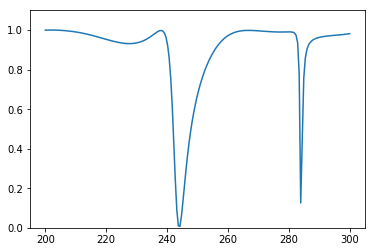

Test 89
True shape: [0.4        0.3        0.2370452  0.2        0.19753767 0.2       ]
Predicted shape: [[0.34798273 0.29563865 0.281951   0.18336982 0.16683263 0.17358221]]

Predicted shape: [[0.43617022 0.29710996 0.23032242 0.17061648 0.16723487 0.22695637]]



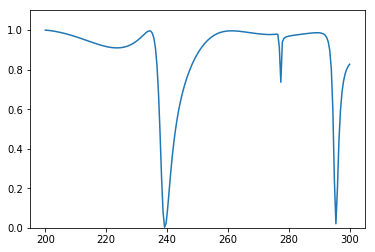

Test 90
True shape: [0.19753767 0.2        0.1        0.2        0.3        0.4       ]
Predicted shape: [[0.23094833 0.1926789  0.11057639 0.20364845 0.28406632 0.40391907]]

Predicted shape: [[0.19371882 0.21310648 0.09847355 0.18470752 0.29954857 0.38328305]]



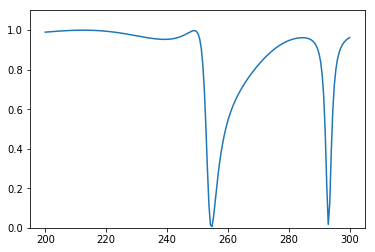

Test 91
True shape: [0.3        0.3        0.2        0.18737194 0.18042261 0.1782013 ]
Predicted shape: [[0.28335243 0.27463004 0.19349292 0.19437802 0.18993863 0.15073328]]

Predicted shape: [[0.27866358 0.3121305  0.20703626 0.18484807 0.18093865 0.17849436]]



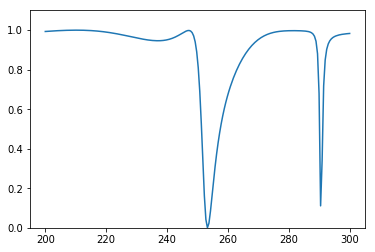

Test 92
True shape: [0.19753767 0.2        0.2        0.2        0.3        0.3       ]
Predicted shape: [[0.19845387 0.20360783 0.19973165 0.19744197 0.29673645 0.29425314]]

Predicted shape: [[0.20246789 0.1967288  0.20248538 0.19164789 0.29993817 0.3206464 ]]



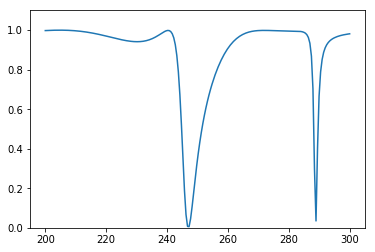

Test 93
True shape: [0.3        0.2        0.2        0.19753767 0.2        0.3       ]
Predicted shape: [[0.3028457  0.2021277  0.19915184 0.19364011 0.19458981 0.28986007]]

Predicted shape: [[0.2767901  0.19941184 0.19993997 0.19721869 0.19530983 0.3149893 ]]



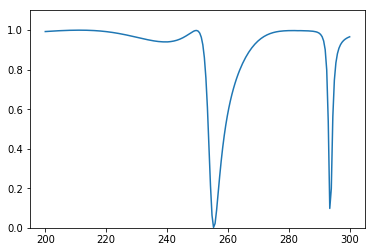

Test 94
True shape: [0.2        0.21968701 0.25051498 0.3        0.2370452  0.2       ]
Predicted shape: [[0.20414251 0.24479255 0.2175008  0.20595607 0.25864536 0.26211482]]

Predicted shape: [[0.19909453 0.22355267 0.2602194  0.2950263  0.25010225 0.21885863]]



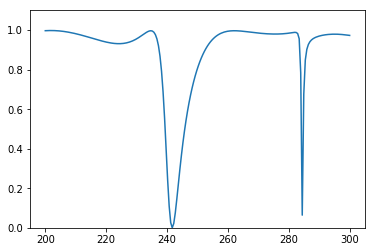

Test 95
True shape: [0.2 0.3 0.3 0.2 0.2 0.2]
Predicted shape: [[0.20276996 0.2935092  0.2248035  0.2174693  0.20997977 0.3047355 ]]

Predicted shape: [[0.21374905 0.3073281  0.298332   0.19007912 0.20457427 0.18301691]]



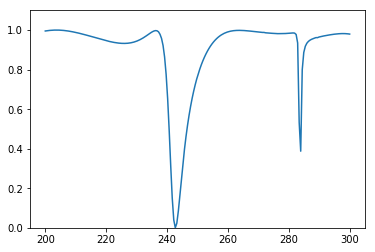

Test 96
True shape: [0.2963065 0.3       0.2963065 0.3       0.2       0.1      ]
Predicted shape: [[0.29300243 0.2924308  0.29576027 0.31640208 0.19017147 0.11674363]]

Predicted shape: [[0.29812616 0.2944268  0.288634   0.2923351  0.19085838 0.08907442]]



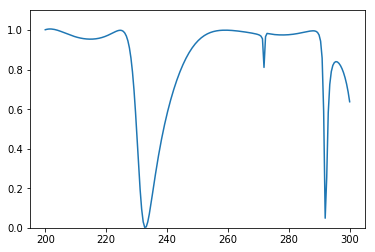

Test 97
True shape: [0.09876883 0.1        0.13169178 0.2        0.3        0.4       ]
Predicted shape: [[0.08093071 0.10647994 0.14708498 0.20798665 0.28849825 0.39552727]]

Predicted shape: [[0.10994717 0.11990994 0.12623131 0.19137323 0.2967625  0.4056428 ]]



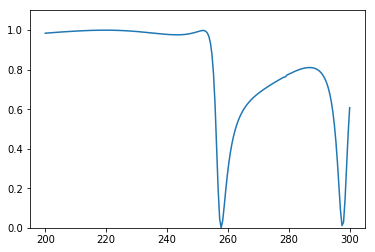

Test 98
True shape: [0.1902113  0.19258231 0.2        0.3        0.3        0.2963065 ]
Predicted shape: [[0.16745475 0.17770341 0.19476661 0.30216402 0.29257444 0.29897562]]

Predicted shape: [[0.1857554  0.18726164 0.20069158 0.29563767 0.30676657 0.29252222]]



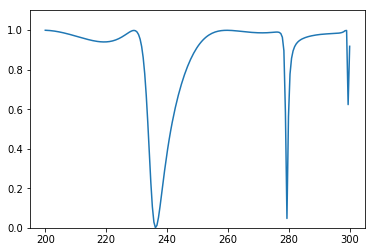

Test 99
True shape: [0.2       0.2370452 0.3       0.2370452 0.2       0.3      ]
Predicted shape: [[0.19916117 0.20818532 0.24883169 0.23958656 0.25395674 0.26582384]]

Predicted shape: [[0.20143259 0.21988651 0.27692592 0.23968962 0.23867446 0.31133005]]



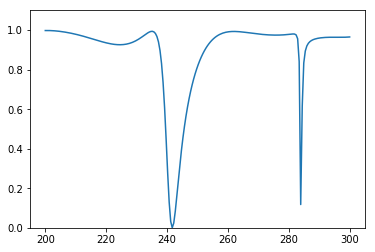

Test 100
True shape: [0.2 0.1 0.2 0.2 0.3 0.3]
Predicted shape: [[0.23043242 0.14273342 0.20744208 0.20616853 0.2720304  0.26757404]]

Predicted shape: [[0.2069625  0.10282218 0.18408978 0.2083188  0.29320636 0.31479502]]



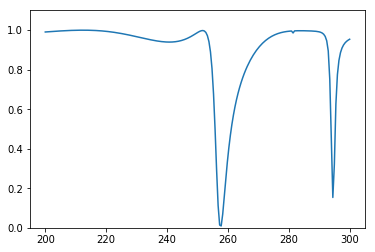

Test 101
True shape: [0.3 0.3 0.2 0.2 0.2 0.1]
Predicted shape: [[0.28415483 0.30181023 0.20787197 0.20285746 0.1647219  0.13619697]]

Predicted shape: [[0.29960713 0.31333405 0.18872172 0.1964995  0.20507675 0.09272096]]



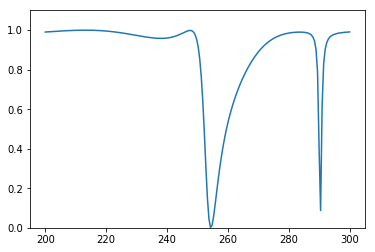

Test 102
True shape: [0.1       0.2       0.3       0.2       0.2370452 0.3      ]
Predicted shape: [[0.09499452 0.19659564 0.30005154 0.23906106 0.20033246 0.29748535]]

Predicted shape: [[0.09936684 0.20945305 0.28744382 0.19505113 0.24777105 0.299346  ]]



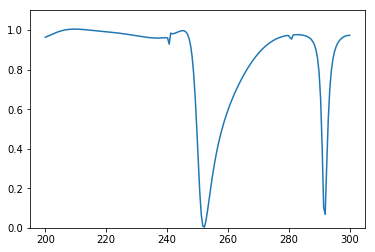

Test 103
True shape: [0.1        0.1        0.2        0.3        0.28887347 0.28531695]
Predicted shape: [[0.08415645 0.11561689 0.19748956 0.30337888 0.27029213 0.28307652]]

Predicted shape: [[0.10226709 0.10488459 0.18560877 0.2738999  0.29277438 0.30095184]]



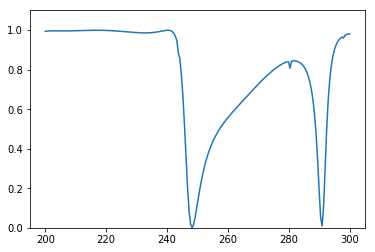

Test 104
True shape: [0.3 0.3 0.2 0.3 0.2 0.1]
Predicted shape: [[0.22534674 0.22354025 0.29766774 0.2952577  0.20500396 0.10489075]]

Predicted shape: [[0.28989315 0.28731048 0.19358262 0.29480237 0.1961013  0.11903581]]



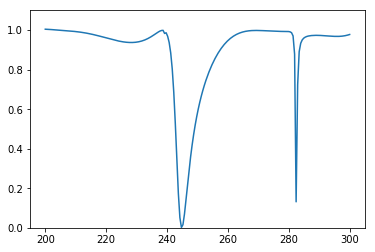

Test 105
True shape: [0.1       0.2       0.3       0.2963065 0.3       0.2      ]
Predicted shape: [[0.09133434 0.20250991 0.24430752 0.29859576 0.277455   0.27185908]]

Predicted shape: [[0.10555157 0.19309819 0.29548362 0.2922697  0.29523662 0.19949034]]



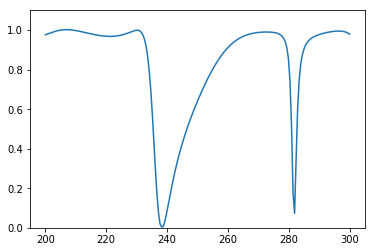

Test 106
True shape: [0.2 0.3 0.2 0.3 0.2 0.1]
Predicted shape: [[0.19255373 0.2212835  0.30096173 0.19461417 0.19730449 0.1452552 ]]

Predicted shape: [[0.20702547 0.26503432 0.21276724 0.28740114 0.20911662 0.09616604]]



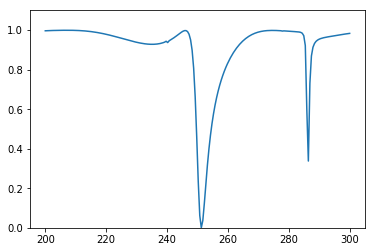

Test 107
True shape: [0.2        0.2        0.2370452  0.3        0.28887347 0.28531695]
Predicted shape: [[0.19600692 0.2891799  0.21315089 0.22112161 0.29814705 0.30250505]]

Predicted shape: [[0.18601891 0.24737376 0.23682386 0.26168957 0.31001297 0.25962955]]



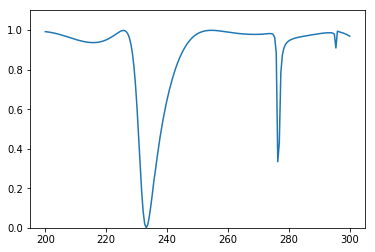

Test 108
True shape: [0.2 0.1 0.2 0.3 0.2 0.3]
Predicted shape: [[0.1889776  0.14037031 0.18014258 0.26040938 0.2466031  0.17810458]]

Predicted shape: [[0.1873829  0.12562889 0.1871959  0.27883488 0.23468141 0.28685892]]



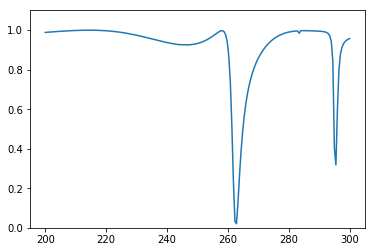

Test 109
True shape: [0.1        0.13169178 0.2        0.3        0.3        0.4       ]
Predicted shape: [[0.08457661 0.15256378 0.23645002 0.26889542 0.2912737  0.3992823 ]]

Predicted shape: [[0.10312429 0.14968958 0.2406328  0.18566939 0.27301654 0.37838972]]



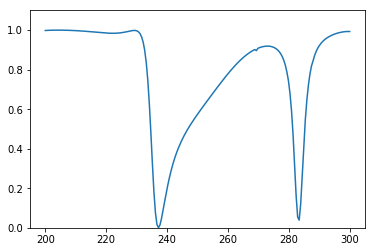

Test 110
True shape: [0.3        0.25051498 0.21968701 0.2        0.3        0.2       ]
Predicted shape: [[0.29103225 0.24133664 0.21604809 0.21618414 0.23072618 0.285694  ]]

Predicted shape: [[0.30820855 0.24030483 0.21801001 0.24487028 0.27932933 0.20981978]]



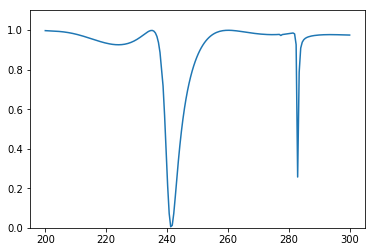

Test 111
True shape: [0.2        0.3        0.3        0.2        0.2        0.19753767]
Predicted shape: [[0.21246046 0.27018481 0.22883835 0.2203274  0.20827956 0.3019835 ]]

Predicted shape: [[0.2151747  0.30911216 0.29198593 0.20109081 0.19502498 0.1807841 ]]



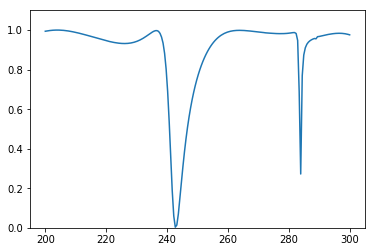

Test 112
True shape: [0.3        0.2        0.21057    0.22825356 0.25606269 0.3       ]
Predicted shape: [[0.3010218  0.27388528 0.24714917 0.19044977 0.18562512 0.24347979]]

Predicted shape: [[0.3159607  0.22518536 0.22473249 0.21940973 0.24320778 0.28754276]]



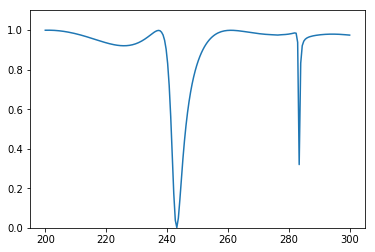

Test 113
True shape: [0.3       0.2370452 0.2       0.2       0.1       0.2      ]
Predicted shape: [[0.2741559  0.26245725 0.24213344 0.18630612 0.11437904 0.14853807]]

Predicted shape: [[0.30606878 0.24878526 0.21824142 0.15184191 0.16398467 0.14353943]]



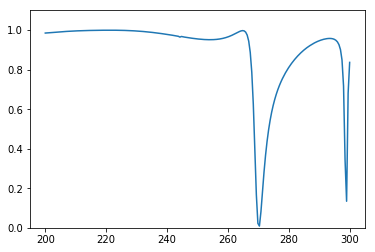

Test 114
True shape: [0.2963065 0.3       0.2       0.1       0.2       0.2      ]
Predicted shape: [[0.296272   0.29690117 0.20926937 0.10586926 0.20536593 0.18398543]]

Predicted shape: [[0.3225123  0.30136615 0.20242468 0.10127705 0.19846575 0.22172046]]



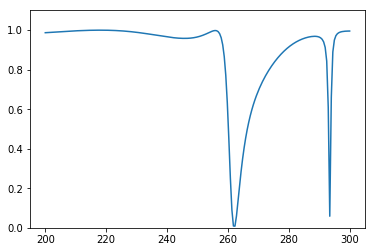

Test 115
True shape: [0.2       0.3       0.2370452 0.2       0.3       0.3      ]
Predicted shape: [[0.23542055 0.18649697 0.21493754 0.30877942 0.31168818 0.22430484]]

Predicted shape: [[0.23964188 0.28322488 0.23634669 0.23365179 0.28104317 0.2558208 ]]



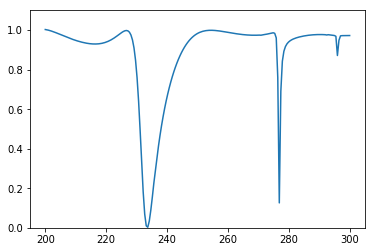

Test 116
True shape: [0.5       0.4389726 0.4       0.3       0.2963065 0.3      ]
Predicted shape: [[0.5017023  0.44623548 0.39790827 0.30686057 0.30381417 0.29024193]]

Predicted shape: [[0.4952058  0.44626185 0.3866837  0.30214202 0.2955636  0.28873864]]



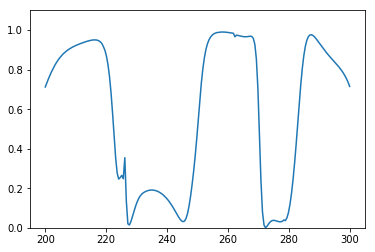

Test 117
True shape: [0.2       0.2370452 0.3       0.2370452 0.2       0.2      ]
Predicted shape: [[0.20828232 0.24160802 0.23407078 0.28294402 0.2120849  0.18464057]]

Predicted shape: [[0.20977253 0.22285101 0.28999278 0.25236723 0.22019157 0.20251276]]



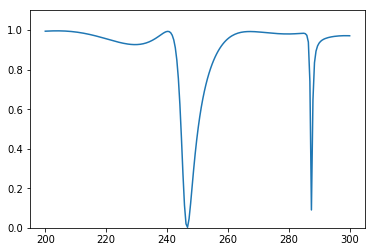

Test 118
True shape: [0.19753767 0.2        0.21968701 0.25051498 0.3        0.3       ]
Predicted shape: [[0.18208742 0.1927383  0.2256493  0.24197942 0.29730368 0.29716167]]

Predicted shape: [[0.19662336 0.20019823 0.21428177 0.24552703 0.30483776 0.30271766]]



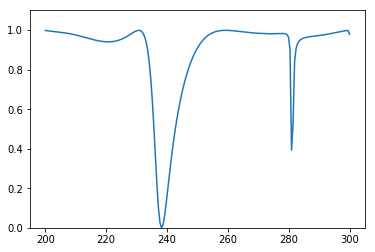

Test 119
True shape: [0.19753767 0.2        0.21968701 0.25051498 0.3        0.4       ]
Predicted shape: [[0.30499834 0.1964049  0.19535732 0.25077665 0.30742714 0.3859395 ]]

Predicted shape: [[0.20961803 0.20446777 0.20642406 0.255276   0.30236912 0.4001447 ]]



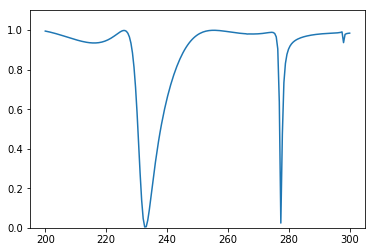

Test 120
True shape: [0.2       0.2       0.2       0.2370452 0.3       0.2963065]
Predicted shape: [[0.18840563 0.19801658 0.20226565 0.23810157 0.3017956  0.2999143 ]]

Predicted shape: [[0.20500699 0.20179155 0.20907849 0.22074237 0.29997694 0.3184826 ]]



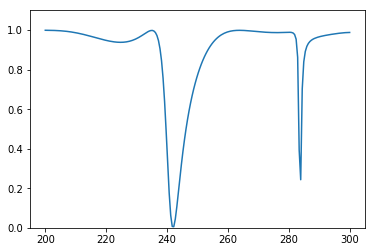

Test 121
True shape: [0.2 0.2 0.3 0.3 0.3 0.2]
Predicted shape: [[0.23281363 0.20645756 0.23416302 0.30798867 0.2865537  0.2583216 ]]

Predicted shape: [[0.20771581 0.19877619 0.2889594  0.3019534  0.29004398 0.2100638 ]]



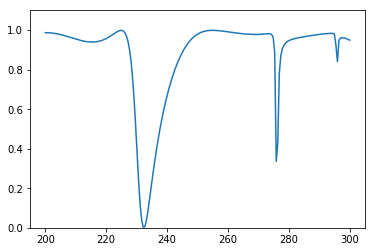

Test 122
True shape: [0.2        0.2        0.21968701 0.25051498 0.3        0.4       ]
Predicted shape: [[0.2919824  0.18790883 0.19464093 0.25729817 0.3063314  0.3906086 ]]

Predicted shape: [[0.21166244 0.20392624 0.20637149 0.24963337 0.30265656 0.40278155]]



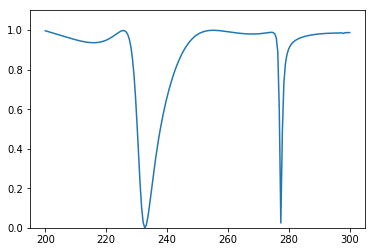

Test 123
True shape: [0.19753767 0.2        0.2370452  0.3        0.3        0.2963065 ]
Predicted shape: [[0.19689557 0.2103881  0.2633149  0.28692484 0.29795268 0.28848252]]

Predicted shape: [[0.20008546 0.19769543 0.23693919 0.29751068 0.29942834 0.29155776]]



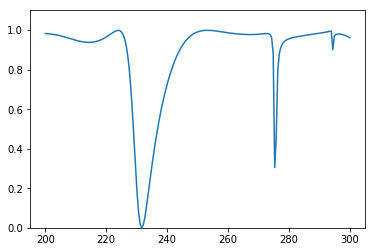

Test 124
True shape: [0.3        0.3        0.2        0.2        0.1        0.09876883]
Predicted shape: [[0.29487115 0.29610786 0.20745254 0.20104977 0.10652274 0.11948369]]

Predicted shape: [[0.30791885 0.29593915 0.19516668 0.18596798 0.10706768 0.09535208]]



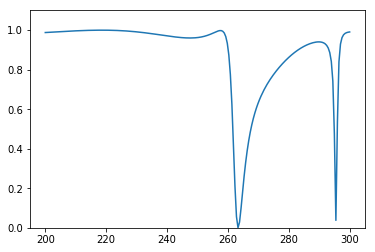

Test 125
True shape: [0.5        0.4        0.338636   0.3        0.2        0.19753767]
Predicted shape: [[0.48695213 0.38016972 0.3348688  0.31627643 0.22230163 0.23413588]]

Predicted shape: [[0.5016013  0.40292904 0.31210095 0.29902768 0.20588906 0.1927478 ]]



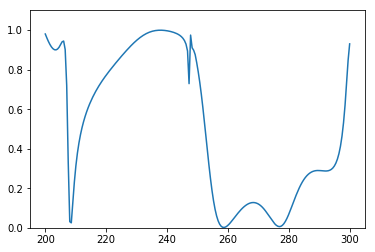

Test 126
True shape: [0.1902113  0.19258231 0.2        0.2370452  0.3        0.2       ]
Predicted shape: [[0.24955365 0.21743143 0.22358674 0.19757321 0.2664473  0.21152744]]

Predicted shape: [[0.20653632 0.1981959  0.17645678 0.2171978  0.29368672 0.22149405]]



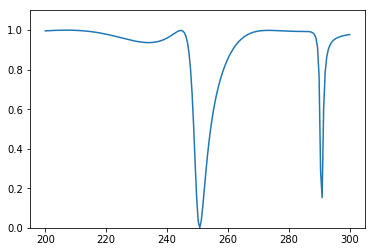

Test 127
True shape: [0.2        0.3        0.2370452  0.2        0.19753767 0.2       ]
Predicted shape: [[0.22433913 0.30371314 0.22596893 0.20824197 0.20602912 0.19504881]]

Predicted shape: [[0.18672088 0.29350662 0.24726367 0.2061019  0.19323029 0.22390682]]



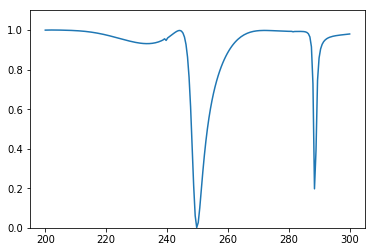

Test 128
True shape: [0.3        0.2        0.19753767 0.2        0.3        0.2963065 ]
Predicted shape: [[0.2532711  0.20059142 0.21235737 0.20185277 0.29466185 0.32323992]]

Predicted shape: [[0.29741925 0.2074728  0.1944797  0.2058377  0.30193332 0.31612962]]



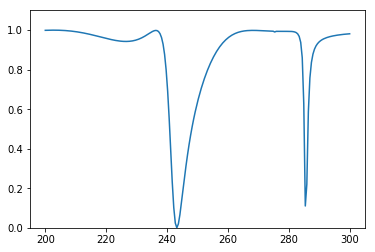

Test 129
True shape: [0.2        0.3        0.2370452  0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.30602488 0.2424553  0.20228606 0.23503026 0.2044576  0.18743244]]

Predicted shape: [[0.22833073 0.28306657 0.2526223  0.18471912 0.2087268  0.18920448]]



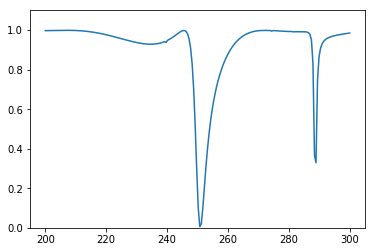

Test 130
True shape: [0.19753767 0.2        0.19753767 0.2        0.3        0.3       ]
Predicted shape: [[0.19866073 0.2010029  0.19782794 0.20018587 0.29835075 0.29563728]]

Predicted shape: [[0.20421451 0.19729277 0.19787684 0.1904194  0.30180174 0.32571265]]



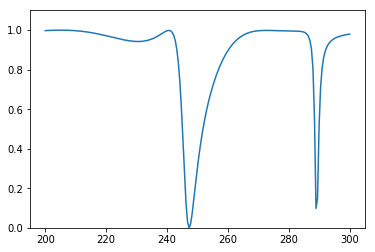

Test 131
True shape: [0.4 0.3 0.3 0.2 0.2 0.1]
Predicted shape: [[0.3125513  0.30020604 0.28780067 0.22353283 0.18796775 0.08458213]]

Predicted shape: [[0.40891892 0.3060053  0.27102005 0.18632916 0.20303793 0.10252962]]



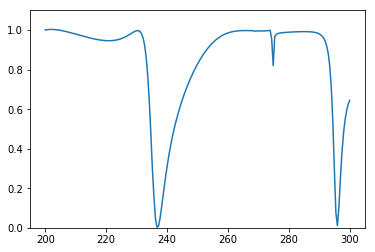

Test 132
True shape: [0.1       0.2       0.3       0.3       0.2370452 0.2      ]
Predicted shape: [[0.13325742 0.21797961 0.25870675 0.2954747  0.22149298 0.29171807]]

Predicted shape: [[0.09550676 0.20395437 0.29750496 0.29303527 0.23414184 0.2124862 ]]



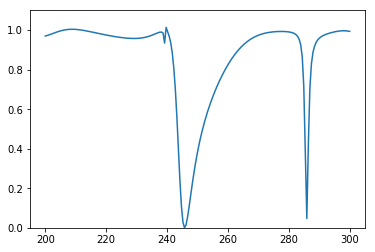

Test 133
True shape: [0.2 0.3 0.3 0.2 0.3 0.2]
Predicted shape: [[0.1993933  0.3115994  0.29435208 0.22373512 0.22096282 0.31205106]]

Predicted shape: [[0.23189577 0.3013792  0.31408942 0.21089378 0.20996231 0.3134702 ]]



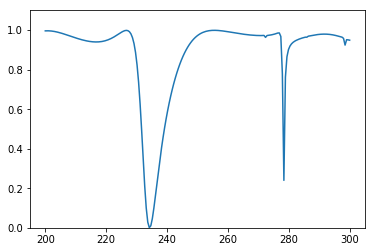

Test 134
True shape: [0.1 0.2 0.2 0.3 0.3 0.4]
Predicted shape: [[0.12174973 0.1432254  0.22368059 0.30828014 0.32037967 0.39839354]]

Predicted shape: [[0.16239053 0.16522172 0.23094052 0.22699273 0.30681407 0.35282663]]



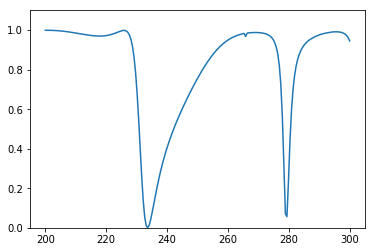

Test 135
True shape: [0.3       0.3       0.292613  0.292613  0.3       0.2963065]
Predicted shape: [[0.29257768 0.29600757 0.30185395 0.29670417 0.2971466  0.30185533]]

Predicted shape: [[0.30083263 0.30188853 0.29515952 0.29601353 0.29793712 0.30278882]]



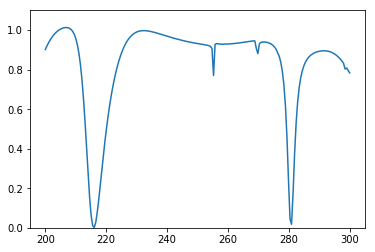

Test 136
True shape: [0.1902113  0.19258231 0.2        0.3        0.3        0.2       ]
Predicted shape: [[0.18485144 0.19836354 0.19770795 0.30007607 0.20364101 0.28166157]]

Predicted shape: [[0.19338167 0.20447388 0.19932878 0.2979719  0.30842906 0.21380715]]



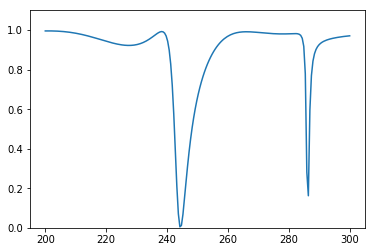

Test 137
True shape: [0.3        0.2963065  0.3        0.2        0.19753767 0.2       ]
Predicted shape: [[0.30321497 0.2583012  0.3015389  0.19146404 0.22414948 0.20532607]]

Predicted shape: [[0.3163375  0.3011198  0.29334086 0.19651037 0.18962544 0.20085396]]



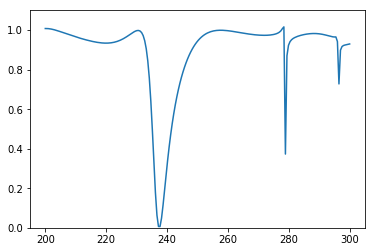

Test 138
True shape: [0.2 0.2 0.2 0.2 0.3 0.3]
Predicted shape: [[0.19565076 0.19644192 0.21359602 0.21007812 0.30039102 0.29744792]]

Predicted shape: [[0.2046892  0.19992128 0.20266223 0.19820622 0.30558157 0.3157725 ]]



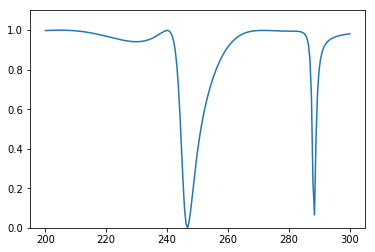

Test 139
True shape: [0.2963065  0.3        0.2        0.13169178 0.1        0.1       ]
Predicted shape: [[0.29368937 0.29384238 0.19041389 0.12916812 0.10711911 0.11178378]]

Predicted shape: [[0.29889327 0.2904879  0.20160246 0.13755363 0.10266829 0.10771757]]



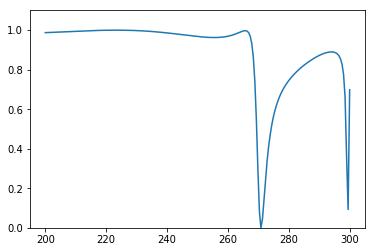

Test 140
True shape: [0.3       0.2       0.2370452 0.3       0.2       0.1      ]
Predicted shape: [[0.29859316 0.21195385 0.22681159 0.26082832 0.20210296 0.12968399]]

Predicted shape: [[0.2918691  0.20702198 0.24630043 0.2795115  0.20226221 0.11168461]]



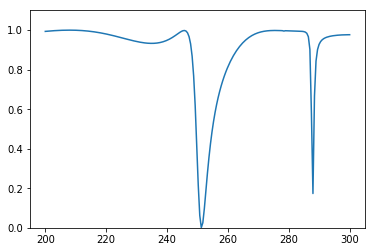

Test 141
True shape: [0.2        0.3        0.2963065  0.3        0.2        0.19753767]
Predicted shape: [[0.25911754 0.25333464 0.21695322 0.29819116 0.2529959  0.25318265]]

Predicted shape: [[0.23642951 0.31077868 0.2899837  0.28672856 0.20869842 0.21115945]]



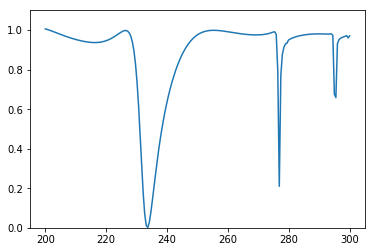

Test 142
True shape: [0.2 0.3 0.2 0.2 0.2 0.3]
Predicted shape: [[0.22062337 0.3026532  0.20610526 0.19596568 0.21119946 0.26485404]]

Predicted shape: [[0.249262   0.29431385 0.17708659 0.19026205 0.20121717 0.28157339]]



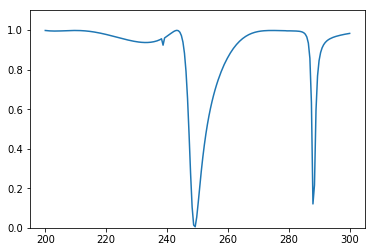

Test 143
True shape: [0.1        0.13169178 0.2        0.2        0.3        0.4       ]
Predicted shape: [[0.1071786  0.15852311 0.20946383 0.21031532 0.29061186 0.33355755]]

Predicted shape: [[0.09431937 0.14245287 0.16635832 0.18413565 0.29645067 0.38893056]]



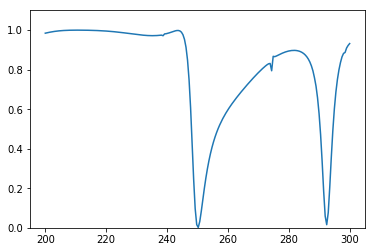

Test 144
True shape: [0.2        0.1        0.2        0.21968701 0.25051498 0.3       ]
Predicted shape: [[0.1972959  0.18393493 0.23699027 0.2217426  0.21085969 0.18244547]]

Predicted shape: [[0.18620205 0.11321518 0.16870266 0.23424754 0.23209918 0.27852553]]



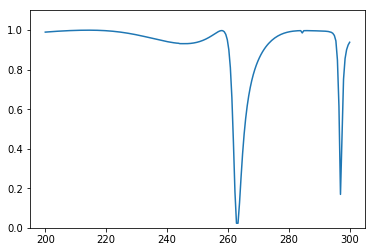

Test 145
True shape: [0.2        0.19753767 0.2        0.2        0.3        0.2963065 ]
Predicted shape: [[0.19716045 0.19556934 0.19558728 0.19576249 0.29816288 0.29812598]]

Predicted shape: [[0.20470276 0.19996664 0.19977424 0.18949366 0.29282063 0.31938565]]



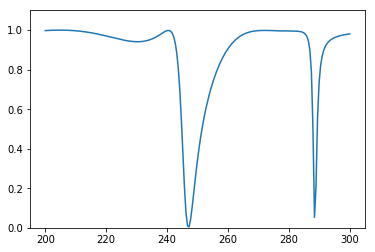

Test 146
True shape: [0.2       0.3       0.2963065 0.3       0.2       0.2      ]
Predicted shape: [[0.21846545 0.26249605 0.21429348 0.2967121  0.25965145 0.26091784]]

Predicted shape: [[0.22115189 0.31017748 0.29600626 0.29117906 0.21045408 0.20635669]]



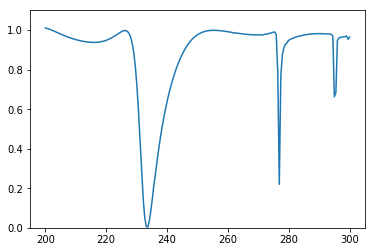

Test 147
True shape: [0.3       0.2370452 0.2       0.2       0.3       0.2963065]
Predicted shape: [[0.29841956 0.25932956 0.20358649 0.19078228 0.30105022 0.28263065]]

Predicted shape: [[0.2887954  0.23540601 0.1872667  0.19037277 0.29105017 0.30355334]]



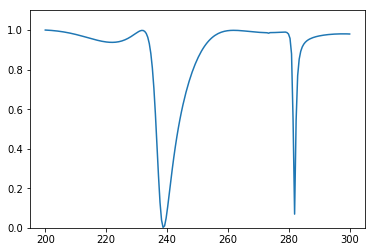

Test 148
True shape: [0.19753767 0.2        0.3        0.2        0.3        0.2       ]
Predicted shape: [[0.19499174 0.21538201 0.28464922 0.28289115 0.21449523 0.20136221]]

Predicted shape: [[0.20847431 0.2037189  0.28546304 0.2424452  0.23831627 0.21554796]]



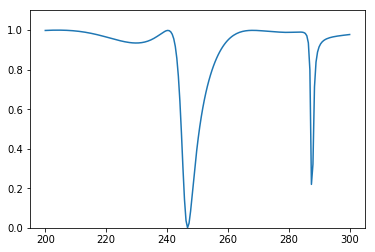

Test 149
True shape: [0.3        0.2        0.19507534 0.19507534 0.2        0.19753767]
Predicted shape: [[0.29684842 0.19616583 0.20237255 0.18905681 0.19068602 0.2014968 ]]

Predicted shape: [[0.30106843 0.20562983 0.19116193 0.18934512 0.20689774 0.21507125]]



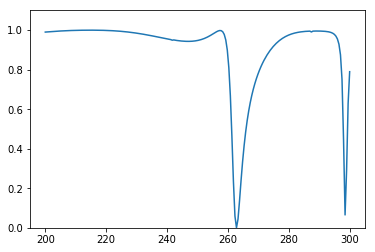

Test 150
True shape: [0.2        0.3        0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.2005491  0.30787635 0.20596534 0.18851966 0.1998765  0.18331565]]

Predicted shape: [[0.20794463 0.2918762  0.19854337 0.19062072 0.20628384 0.20628598]]



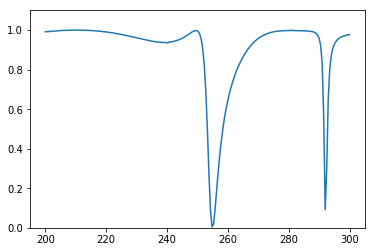

Test 151
True shape: [0.2       0.3       0.2370452 0.2       0.3       0.2      ]
Predicted shape: [[0.17650226 0.28139096 0.30782953 0.21572241 0.20749812 0.29026017]]

Predicted shape: [[0.19911355 0.2991669  0.24036044 0.24197519 0.26276296 0.20874687]]



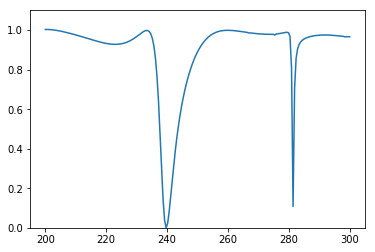

Test 152
True shape: [0.2963065 0.3       0.2       0.2370452 0.3       0.2963065]
Predicted shape: [[0.30935663 0.2901361  0.20859051 0.23139238 0.29729572 0.31601116]]

Predicted shape: [[0.2958603  0.26299793 0.20397738 0.23273173 0.29597113 0.3172689 ]]



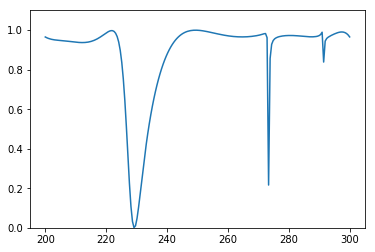

Test 153
True shape: [0.2        0.2        0.21057    0.22825356 0.25606269 0.3       ]
Predicted shape: [[0.24070844 0.21969396 0.22737584 0.2204895  0.22219585 0.27064618]]

Predicted shape: [[0.21403155 0.20705771 0.2322639  0.2185998  0.25074306 0.30418077]]



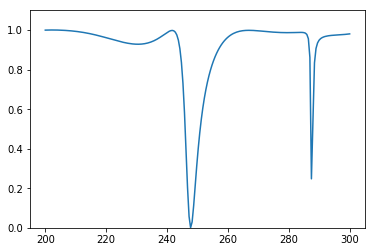

Test 154
True shape: [0.2        0.2        0.3        0.2        0.2        0.19753767]
Predicted shape: [[0.16720608 0.19343278 0.2938044  0.21507677 0.20058861 0.18714297]]

Predicted shape: [[0.19502586 0.20096889 0.305517   0.2169489  0.20247361 0.19297546]]



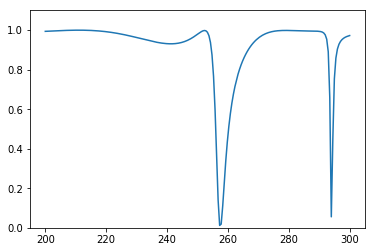

Test 155
True shape: [0.26730196 0.27063391 0.28105791 0.3        0.3        0.3       ]
Predicted shape: [[0.2507474  0.26386827 0.2935074  0.31064025 0.30292535 0.27951315]]

Predicted shape: [[0.27399957 0.27191103 0.281985   0.28774637 0.2915828  0.30119002]]



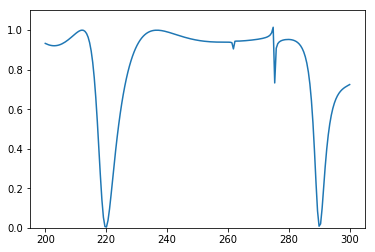

Test 156
True shape: [0.3 0.2 0.2 0.2 0.3 0.4]
Predicted shape: [[0.2513572  0.1916922  0.19225672 0.20761022 0.28603262 0.4302735 ]]

Predicted shape: [[0.29966068 0.20779654 0.19462532 0.20953691 0.29057968 0.3991235 ]]



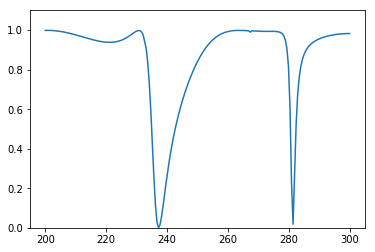

Test 157
True shape: [0.2        0.13169178 0.1        0.2        0.3        0.4       ]
Predicted shape: [[0.16469029 0.1253595  0.15709832 0.21735647 0.30234852 0.3860383 ]]

Predicted shape: [[0.20710972 0.12843022 0.10499188 0.19517994 0.2671274  0.4092131 ]]



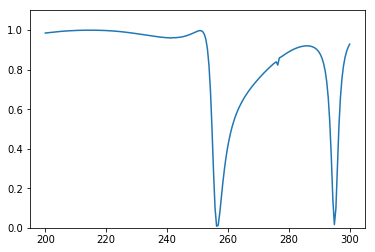

Test 158
True shape: [0.2       0.2       0.2       0.2       0.3       0.2963065]
Predicted shape: [[0.2008011  0.19488603 0.20093066 0.20215023 0.3037004  0.30558857]]

Predicted shape: [[0.20504713 0.20152393 0.20170265 0.19307306 0.2953575  0.31576052]]



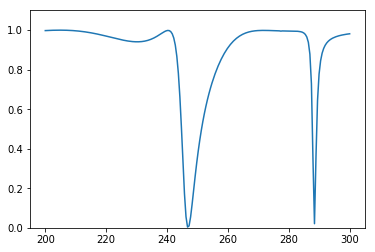

Test 159
True shape: [0.4        0.4        0.4        0.39507534 0.4        0.5       ]
Predicted shape: [[0.2621954  0.24483445 0.19039705 0.27080965 0.22229591 0.24257022]]

Predicted shape: [[0.40291232 0.4053325  0.4013691  0.39047757 0.40416163 0.5106339 ]]



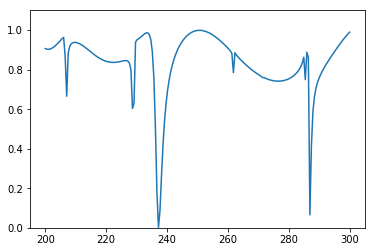

Test 160
True shape: [0.3        0.28887347 0.28531695 0.28887347 0.3        0.3       ]
Predicted shape: [[0.28932303 0.27467227 0.2878111  0.2988423  0.28528318 0.3008977 ]]

Predicted shape: [[0.29770306 0.29733887 0.29488778 0.29568678 0.29808387 0.30818403]]



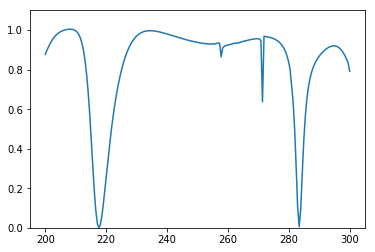

Test 161
True shape: [0.3 0.2 0.2 0.3 0.2 0.2]
Predicted shape: [[0.2815873  0.19613662 0.20746699 0.3040341  0.21003814 0.1789506 ]]

Predicted shape: [[0.27432796 0.20729443 0.22379434 0.29464194 0.20292547 0.2055086 ]]



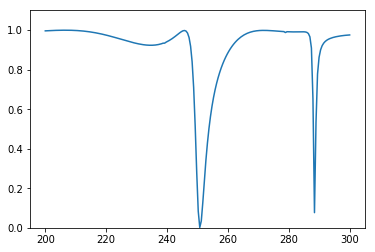

Test 162
True shape: [0.2        0.3        0.2723943  0.25519524 0.24573045 0.2427051 ]
Predicted shape: [[0.22141618 0.26343876 0.24012586 0.26850766 0.2766513  0.20218155]]

Predicted shape: [[0.22551182 0.2954789  0.3030907  0.22686031 0.25541276 0.26237655]]



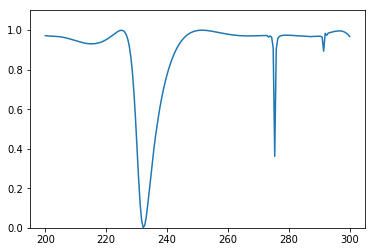

Test 163
True shape: [0.3      0.292613 0.292613 0.3      0.3      0.3     ]
Predicted shape: [[0.29022163 0.29644787 0.30085713 0.30154675 0.2912696  0.28741756]]

Predicted shape: [[0.30510873 0.29952526 0.29771543 0.29353684 0.29901776 0.30684033]]



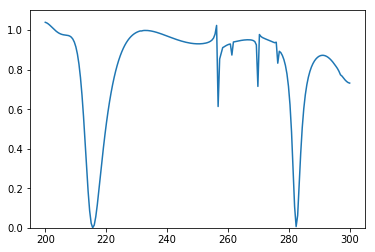

Test 164
True shape: [0.2        0.3        0.2        0.18737194 0.18042261 0.1782013 ]
Predicted shape: [[0.27278933 0.23132801 0.22695893 0.19911072 0.19206399 0.17336994]]

Predicted shape: [[0.20379245 0.2954914  0.21411955 0.19474891 0.17009677 0.20616692]]



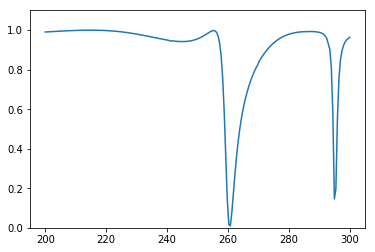

Test 165
True shape: [0.1       0.2       0.2       0.2370452 0.3       0.4      ]
Predicted shape: [[0.08993033 0.17652676 0.23413646 0.28639865 0.28227973 0.31476456]]

Predicted shape: [[0.1025182  0.18420565 0.18933424 0.23901516 0.3050955  0.39104748]]



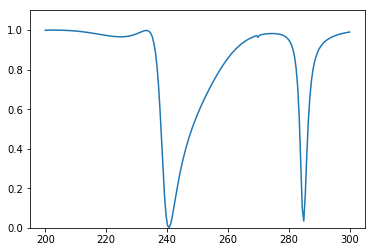

Test 166
True shape: [0.2        0.3        0.3        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.2770089  0.20720151 0.28970173 0.24212804 0.2051476  0.21051237]]

Predicted shape: [[0.21893305 0.29576075 0.2892512  0.22453707 0.18196155 0.20497122]]



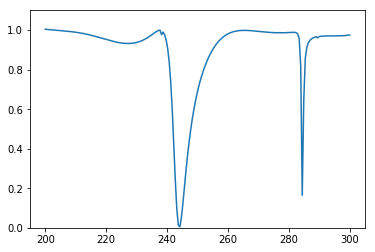

Test 167
True shape: [0.3 0.2 0.2 0.3 0.3 0.2]
Predicted shape: [[0.1906279  0.20243526 0.2173382  0.3013088  0.311284   0.21062075]]

Predicted shape: [[0.23795986 0.20982733 0.23610213 0.2874341  0.29343596 0.20509629]]



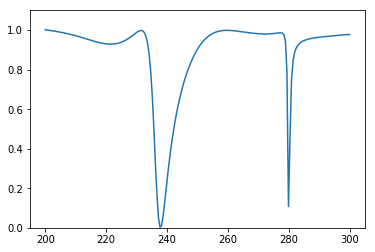

In [6]:
predicted = []
DFNN_all = load_model('DFNN_all')
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_X)):
    print('Test '+str(i))
    print('True shape: ' + str(test_Y[i]))
    print('Predicted shape: ' + str(model.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    print('Predicted shape: ' + str(DFNN_all.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    plt.ylim(0, 1.1)
    plt.plot(x, np.subtract(test_X[i], -0.5))
    plt.show()
    predicted.append(*model.predict(np.reshape(test_X[i], (1, 200))))
    

In [16]:
model.save('two_peak_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('two_peak_model.h5')

In [ ]:
predicted = []
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_X)):
    print('Test '+str(i))
    print('True shape: ' + str(test_Y[i]))
    print('Predicted shape: ' + str(model.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    plt.ylim(0, 1.1)
    plt.plot(x, np.subtract(test_X[i], -0.5))
    plt.show()
    predicted.append(*model.predict(np.reshape(test_X[i], (1, 200))))
    print(test_X[i])